In [1]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.metrics import mean_absolute_percentage_error
from prophet import Prophet
import time
from openpyxl import Workbook

C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# # Membaca data dari file CSV
# df = pd.read_csv('DataReady.csv', parse_dates=['Date'])
# df.columns = ['ds', 'y']
# print(df.sample(5))

In [3]:
# Membaca data dari file CSV
df = pd.read_csv('DataT.csv', parse_dates=['Date'])

# Menyesuaikan format kolom sesuai Prophet
df['ds'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')


df = df.drop(['Date', 'Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
df.columns = ['y', 'ds']

# Membersihkan data dari nilai kosong
df = df.dropna()

# Menampilkan sampel data
print("Sampel Data:")
print(df.sample(5))

Sampel Data:
        y         ds
725  3950 2023-07-10
794  3750 2023-10-18
451  4200 2022-05-25
81   3040 2020-11-12
721  3970 2023-07-04


In [4]:
# Membagi data menjadi data latih dan uji
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

# Menampilkan sampel data latih dan uji
print("Data Latih:")
print(train_data.head())
print("Data Uji:")
print(test_data.head())

print("Jumlah baris pada test_data:", train_data.shape[0])
print("Jumlah baris pada test_data:", test_data.shape[0])

Data Latih:
      y         ds
0  3090 2020-07-13
1  3080 2020-07-14
2  3090 2020-07-15
3  3100 2020-07-16
4  3060 2020-07-17
Data Uji:
        y         ds
772  3720 2023-09-15
773  3680 2023-09-18
774  3730 2023-09-19
775  3810 2023-09-20
776  3810 2023-09-21
Jumlah baris pada test_data: 772
Jumlah baris pada test_data: 193


In [5]:
# Membuat dan melatih model Prophet tanpa tuning
model_default = Prophet()

# Mengukur waktu pelatihan
start_time = time.time()
model_default.fit(train_data)
end_time = time.time()

print(f"Waktu pelatihan model tanpa tuning: {end_time - start_time:.2f} detik")


03:43:09 - cmdstanpy - INFO - Chain [1] start processing
03:43:09 - cmdstanpy - INFO - Chain [1] done processing


Waktu pelatihan model tanpa tuning: 0.46 detik


In [6]:
# Membuat DataFrame untuk prediksi
future = model_default.make_future_dataframe(periods=193)

# Melakukan prediksi tanpa tuning
forecast_default = model_default.predict(future)

# Menampilkan hasil prediksi
print("Hasil Prediksi Tanpa Tuning:")
print(forecast_default[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())


Hasil Prediksi Tanpa Tuning:
          ds         yhat   yhat_lower   yhat_upper
0 2020-07-13  3025.413914  2884.877343  3158.378483
1 2020-07-14  3016.364853  2880.886637  3158.108789
2 2020-07-15  3017.324777  2873.865707  3158.460001
3 2020-07-16  3020.949049  2867.272291  3158.473469
4 2020-07-17  3017.230313  2869.207822  3168.547930


In [7]:
# Hyperparameter tuning dengan random search
param_grid = {
    'changepoint_prior_scale': [0.001, 0.05, 0.1, 0.15, 0.2],
    'seasonality_prior_scale': [0.005, 0.01, 0.015, 0.02],
    'seasonality_mode': ['additive', 'multiplicative'],
    'holidays_prior_scale': [0.08, 0.09, 0.1, 0.11, 0.12],
    'interval_width': [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
}
random_search = list(ParameterSampler(param_grid, n_iter=1400, random_state=42))

best_params = None
best_mape = float('inf')
best_trial = None  # Menyimpan nomor percobaan dengan MAPE terbaik

# List untuk menyimpan hasil percobaan dan MAPE
results = []

# Mulai pencatatan waktu
start_time = time.time()

for i, params in enumerate(random_search, 1):
    print(f"Testing parameters: {params}")  # Log parameter yang sedang diuji
    
    # Membuat model dengan parameter tertentu
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        seasonality_mode=params['seasonality_mode'],
        holidays_prior_scale=params['holidays_prior_scale'],
        interval_width=params['interval_width']
    )
    model.fit(train_data)
    forecast = model.predict(future)

    # Menyamakan tanggal antara data uji dan hasil prediksi
    test_forecast = forecast[forecast['ds'].isin(test_data['ds'])].copy()
    test_actual = test_data[test_data['ds'].isin(test_forecast['ds'])].copy()

    # Validasi jumlah sampel sebelum evaluasi
    if len(test_forecast) != len(test_actual):
        print(f"Skipping due to mismatched samples: {len(test_forecast)} vs {len(test_actual)}")
        continue

    # Menghitung MAPE
    mape = mean_absolute_percentage_error(test_actual['y'], test_forecast['yhat']) * 100
    
    # Simpan hasil percobaan dan MAPE
    results.append({"percobaan ke-n": i, "nilai MAPE": mape})
    
    if mape < best_mape:
        best_mape = mape
        best_params = params
        best_trial = i  # Menyimpan nomor percobaan dengan MAPE terbaik

# Akhiri pencatatan waktu
end_time = time.time()

print(f"Parameter Terbaik: {best_params}\nMAPE Terbaik: {best_mape:.2f}%")
print(f"MAPE terbaik ditemukan pada percobaan ke-{best_trial}")  # Menampilkan nomor percobaan terbaik
print(f"Waktu yang dibutuhkan untuk tuning: {end_time - start_time:.2f} detik")

# Simpan hasil ke file Excel
results_df = pd.DataFrame(results)
results_df.to_excel("hasil_mape_tuning.xlsx", index=False, engine='openpyxl')

print("Hasil MAPE telah disimpan ke dalam file 'hasil_mape_tuning.xlsx'")


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:10 - cmdstanpy - INFO - Chain [1] start processing
03:43:10 - cmdstanpy - INFO - Chain [1] done processing
03:43:10 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:11 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:11 - cmdstanpy - INFO - Chain [1] start processing
03:43:11 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:12 - cmdstanpy - INFO - Chain [1] start processing
03:43:12 - cmdstanpy - INFO - Chain [1] done processing
03:43:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:12 - cmdstanpy - INFO - Chain [1] done processing
03:43:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:13 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:14 - cmdstanpy - INFO - Chain [1] start processing
03:43:14 - cmdstanpy - INFO - Chain [1] done processing
03:43:14 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:14 - cmdstanpy - INFO - Chain [1] done processing
03:43:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:15 - cmdstanpy - INFO - Chain [1] done processing
03:43:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:15 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:16 - cmdstanpy - INFO - Chain [1] start processing
03:43:16 - cmdstanpy - INFO - Chain [1] done processing
03:43:16 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:16 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:17 - cmdstanpy - INFO - Chain [1] start processing
03:43:17 - cmdstanpy - INFO - Chain [1] done processing
03:43:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:18 - cmdstanpy - INFO - Chain [1] done processing
03:43:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:18 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:18 - cmdstanpy - INFO - Chain [1] start processing
03:43:19 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:19 - cmdstanpy - INFO - Chain [1] start processing
03:43:19 - cmdstanpy - INFO - Chain [1] done processing
03:43:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:20 - cmdstanpy - INFO - Chain [1] done processing
03:43:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:20 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:21 - cmdstanpy - INFO - Chain [1] start processing
03:43:21 - cmdstanpy - INFO - Chain [1] done processing
03:43:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:21 - cmdstanpy - INFO - Chain [1] done processing
03:43:22 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:22 - cmdstanpy - INFO - Chain [1] done processing
03:43:22 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:23 - cmdstanpy - INFO - Chain [1] done processing
03:43:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:23 - cmdstanpy - INFO - Chain [1] done processing
03:43:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:24 - cmdstanpy - INFO - Chain [1] done processing
03:43:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:24 - cmdstanpy - INFO - Chain [1] done processing
03:43:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:25 - cmdstanpy - INFO - Chain [1] done processing
03:43:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:25 - cmdstanpy - INFO - Chain [1] done processing
03:43:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:26 - cmdstanpy - INFO - Chain [1] done processing
03:43:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:26 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:27 - cmdstanpy - INFO - Chain [1] start processing
03:43:27 - cmdstanpy - INFO - Chain [1] done processing
03:43:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:27 - cmdstanpy - INFO - Chain [1] done processing
03:43:28 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:28 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:29 - cmdstanpy - INFO - Chain [1] start processing
03:43:29 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:29 - cmdstanpy - INFO - Chain [1] start processing
03:43:29 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:30 - cmdstanpy - INFO - Chain [1] start processing
03:43:30 - cmdstanpy - INFO - Chain [1] done processing
03:43:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:31 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:31 - cmdstanpy - INFO - Chain [1] start processing
03:43:31 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:32 - cmdstanpy - INFO - Chain [1] start processing
03:43:32 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:33 - cmdstanpy - INFO - Chain [1] start processing
03:43:33 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:34 - cmdstanpy - INFO - Chain [1] start processing
03:43:34 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:35 - cmdstanpy - INFO - Chain [1] start processing
03:43:35 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:35 - cmdstanpy - INFO - Chain [1] start processing
03:43:35 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:36 - cmdstanpy - INFO - Chain [1] start processing
03:43:36 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:37 - cmdstanpy - INFO - Chain [1] start processing
03:43:37 - cmdstanpy - INFO - Chain [1] done processing
03:43:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:38 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:38 - cmdstanpy - INFO - Chain [1] start processing
03:43:38 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:39 - cmdstanpy - INFO - Chain [1] start processing
03:43:39 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:40 - cmdstanpy - INFO - Chain [1] start processing
03:43:40 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:40 - cmdstanpy - INFO - Chain [1] start processing
03:43:40 - cmdstanpy - INFO - Chain [1] done processing
03:43:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:41 - cmdstanpy - INFO - Chain [1] done processing
03:43:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:41 - cmdstanpy - INFO - Chain [1] done processing
03:43:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:42 - cmdstanpy - INFO - Chain [1] done processing
03:43:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:42 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:43 - cmdstanpy - INFO - Chain [1] start processing
03:43:43 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.001}


03:43:44 - cmdstanpy - INFO - Chain [1] start processing
03:43:44 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:43:44 - cmdstanpy - INFO - Chain [1] start processing
03:43:44 - cmdstanpy - INFO - Chain [1] done processing
03:43:45 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:43:45 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:43:46 - cmdstanpy - INFO - Chain [1] start processing
03:43:46 - cmdstanpy - INFO - Chain [1] done processing
03:43:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:43:46 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:43:47 - cmdstanpy - INFO - Chain [1] start processing
03:43:47 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:43:48 - cmdstanpy - INFO - Chain [1] start processing
03:43:48 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:43:48 - cmdstanpy - INFO - Chain [1] start processing
03:43:48 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:43:49 - cmdstanpy - INFO - Chain [1] start processing
03:43:49 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:43:50 - cmdstanpy - INFO - Chain [1] start processing
03:43:50 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:43:51 - cmdstanpy - INFO - Chain [1] start processing
03:43:51 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:43:52 - cmdstanpy - INFO - Chain [1] start processing
03:43:52 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:43:52 - cmdstanpy - INFO - Chain [1] start processing
03:43:52 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:43:53 - cmdstanpy - INFO - Chain [1] start processing
03:43:53 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:43:54 - cmdstanpy - INFO - Chain [1] start processing
03:43:54 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:43:55 - cmdstanpy - INFO - Chain [1] start processing
03:43:55 - cmdstanpy - INFO - Chain [1] done processing
03:43:55 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:43:56 - cmdstanpy - INFO - Chain [1] done processing
03:43:56 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:43:56 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:43:57 - cmdstanpy - INFO - Chain [1] start processing
03:43:57 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:43:57 - cmdstanpy - INFO - Chain [1] start processing
03:43:57 - cmdstanpy - INFO - Chain [1] done processing
03:43:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:43:58 - cmdstanpy - INFO - Chain [1] done processing
03:43:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:43:58 - cmdstanpy - INFO - Chain [1] done processing
03:43:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:43:59 - cmdstanpy - INFO - Chain [1] done processing
03:43:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:43:59 - cmdstanpy - INFO - Chain [1] done processing
03:44:00 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:00 - cmdstanpy - INFO - Chain [1] done processing
03:44:00 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:00 - cmdstanpy - INFO - Chain [1] done processing
03:44:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:01 - cmdstanpy - INFO - Chain [1] done processing
03:44:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:01 - cmdstanpy - INFO - Chain [1] done processing
03:44:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:02 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:03 - cmdstanpy - INFO - Chain [1] start processing
03:44:03 - cmdstanpy - INFO - Chain [1] done processing
03:44:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:03 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:04 - cmdstanpy - INFO - Chain [1] start processing
03:44:04 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:04 - cmdstanpy - INFO - Chain [1] start processing
03:44:04 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:05 - cmdstanpy - INFO - Chain [1] start processing
03:44:05 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:05 - cmdstanpy - INFO - Chain [1] start processing
03:44:05 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:06 - cmdstanpy - INFO - Chain [1] start processing
03:44:06 - cmdstanpy - INFO - Chain [1] done processing
03:44:06 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:06 - cmdstanpy - INFO - Chain [1] done processing
03:44:07 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:07 - cmdstanpy - INFO - Chain [1] done processing
03:44:07 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:07 - cmdstanpy - INFO - Chain [1] done processing
03:44:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:08 - cmdstanpy - INFO - Chain [1] done processing
03:44:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:08 - cmdstanpy - INFO - Chain [1] done processing
03:44:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:09 - cmdstanpy - INFO - Chain [1] done processing
03:44:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:09 - cmdstanpy - INFO - Chain [1] done processing
03:44:10 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:10 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:10 - cmdstanpy - INFO - Chain [1] start processing
03:44:10 - cmdstanpy - INFO - Chain [1] done processing
03:44:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:11 - cmdstanpy - INFO - Chain [1] done processing
03:44:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:11 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:12 - cmdstanpy - INFO - Chain [1] start processing
03:44:12 - cmdstanpy - INFO - Chain [1] done processing
03:44:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:12 - cmdstanpy - INFO - Chain [1] done processing
03:44:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:13 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:13 - cmdstanpy - INFO - Chain [1] start processing
03:44:13 - cmdstanpy - INFO - Chain [1] done processing
03:44:14 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:14 - cmdstanpy - INFO - Chain [1] done processing
03:44:14 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:15 - cmdstanpy - INFO - Chain [1] done processing
03:44:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:15 - cmdstanpy - INFO - Chain [1] done processing
03:44:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:15 - cmdstanpy - INFO - Chain [1] done processing
03:44:16 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:16 - cmdstanpy - INFO - Chain [1] done processing
03:44:16 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.001}


03:44:16 - cmdstanpy - INFO - Chain [1] done processing
03:44:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:17 - cmdstanpy - INFO - Chain [1] done processing
03:44:17 - cmdstanpy - INFO - Chain [1] start processing
03:44:17 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:18 - cmdstanpy - INFO - Chain [1] done processing
03:44:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:18 - cmdstanpy - INFO - Chain [1] done processing
03:44:19 - cmdstanpy - INFO - Chain [1] start processing
03:44:19 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:19 - cmdstanpy - INFO - Chain [1] done processing
03:44:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:20 - cmdstanpy - INFO - Chain [1] done processing
03:44:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:20 - cmdstanpy - INFO - Chain [1] done processing
03:44:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:21 - cmdstanpy - INFO - Chain [1] done processing
03:44:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:22 - cmdstanpy - INFO - Chain [1] done processing
03:44:22 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:22 - cmdstanpy - INFO - Chain [1] done processing
03:44:22 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:23 - cmdstanpy - INFO - Chain [1] done processing
03:44:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:23 - cmdstanpy - INFO - Chain [1] done processing
03:44:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:24 - cmdstanpy - INFO - Chain [1] done processing
03:44:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:24 - cmdstanpy - INFO - Chain [1] done processing
03:44:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:25 - cmdstanpy - INFO - Chain [1] done processing
03:44:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:25 - cmdstanpy - INFO - Chain [1] done processing
03:44:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:26 - cmdstanpy - INFO - Chain [1] done processing
03:44:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:26 - cmdstanpy - INFO - Chain [1] done processing
03:44:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:27 - cmdstanpy - INFO - Chain [1] done processing
03:44:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:27 - cmdstanpy - INFO - Chain [1] done processing
03:44:28 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:28 - cmdstanpy - INFO - Chain [1] done processing
03:44:28 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:28 - cmdstanpy - INFO - Chain [1] done processing
03:44:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:29 - cmdstanpy - INFO - Chain [1] done processing
03:44:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:30 - cmdstanpy - INFO - Chain [1] done processing
03:44:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:30 - cmdstanpy - INFO - Chain [1] done processing
03:44:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:31 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:31 - cmdstanpy - INFO - Chain [1] start processing
03:44:31 - cmdstanpy - INFO - Chain [1] done processing
03:44:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:31 - cmdstanpy - INFO - Chain [1] done processing
03:44:32 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:32 - cmdstanpy - INFO - Chain [1] done processing
03:44:32 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:33 - cmdstanpy - INFO - Chain [1] done processing
03:44:33 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:33 - cmdstanpy - INFO - Chain [1] done processing
03:44:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:34 - cmdstanpy - INFO - Chain [1] done processing
03:44:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:34 - cmdstanpy - INFO - Chain [1] done processing
03:44:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:35 - cmdstanpy - INFO - Chain [1] done processing
03:44:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:35 - cmdstanpy - INFO - Chain [1] done processing
03:44:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:36 - cmdstanpy - INFO - Chain [1] done processing
03:44:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:36 - cmdstanpy - INFO - Chain [1] done processing
03:44:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:37 - cmdstanpy - INFO - Chain [1] done processing
03:44:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:37 - cmdstanpy - INFO - Chain [1] done processing
03:44:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:38 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:38 - cmdstanpy - INFO - Chain [1] start processing
03:44:38 - cmdstanpy - INFO - Chain [1] done processing
03:44:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:39 - cmdstanpy - INFO - Chain [1] done processing
03:44:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:39 - cmdstanpy - INFO - Chain [1] done processing
03:44:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:40 - cmdstanpy - INFO - Chain [1] done processing
03:44:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:41 - cmdstanpy - INFO - Chain [1] done processing
03:44:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:41 - cmdstanpy - INFO - Chain [1] done processing
03:44:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:42 - cmdstanpy - INFO - Chain [1] done processing
03:44:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:42 - cmdstanpy - INFO - Chain [1] done processing
03:44:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:43 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:43 - cmdstanpy - INFO - Chain [1] start processing
03:44:43 - cmdstanpy - INFO - Chain [1] done processing
03:44:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:44 - cmdstanpy - INFO - Chain [1] done processing
03:44:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:44 - cmdstanpy - INFO - Chain [1] done processing
03:44:45 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:45 - cmdstanpy - INFO - Chain [1] done processing
03:44:45 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:45 - cmdstanpy - INFO - Chain [1] done processing
03:44:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.001}


03:44:46 - cmdstanpy - INFO - Chain [1] done processing
03:44:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:44:46 - cmdstanpy - INFO - Chain [1] done processing
03:44:47 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:44:47 - cmdstanpy - INFO - Chain [1] done processing
03:44:47 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:44:47 - cmdstanpy - INFO - Chain [1] done processing
03:44:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:44:48 - cmdstanpy - INFO - Chain [1] done processing
03:44:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:44:48 - cmdstanpy - INFO - Chain [1] done processing
03:44:49 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:44:49 - cmdstanpy - INFO - Chain [1] done processing
03:44:49 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:44:49 - cmdstanpy - INFO - Chain [1] done processing
03:44:50 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:44:50 - cmdstanpy - INFO - Chain [1] done processing
03:44:50 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:44:50 - cmdstanpy - INFO - Chain [1] done processing
03:44:51 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:44:51 - cmdstanpy - INFO - Chain [1] done processing
03:44:51 - cmdstanpy - INFO - Chain [1] start processing
03:44:52 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:44:52 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:44:52 - cmdstanpy - INFO - Chain [1] done processing
03:44:52 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:44:53 - cmdstanpy - INFO - Chain [1] done processing
03:44:53 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:44:53 - cmdstanpy - INFO - Chain [1] done processing
03:44:54 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:44:54 - cmdstanpy - INFO - Chain [1] done processing
03:44:54 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:44:54 - cmdstanpy - INFO - Chain [1] done processing
03:44:55 - cmdstanpy - INFO - Chain [1] start processing
03:44:55 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:44:55 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:44:55 - cmdstanpy - INFO - Chain [1] done processing
03:44:56 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:44:56 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:44:56 - cmdstanpy - INFO - Chain [1] start processing
03:44:56 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:44:57 - cmdstanpy - INFO - Chain [1] start processing
03:44:57 - cmdstanpy - INFO - Chain [1] done processing
03:44:57 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:44:57 - cmdstanpy - INFO - Chain [1] done processing
03:44:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:44:58 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:44:58 - cmdstanpy - INFO - Chain [1] start processing
03:44:59 - cmdstanpy - INFO - Chain [1] done processing
03:44:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:44:59 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:44:59 - cmdstanpy - INFO - Chain [1] start processing
03:45:00 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:45:00 - cmdstanpy - INFO - Chain [1] start processing
03:45:00 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:45:01 - cmdstanpy - INFO - Chain [1] start processing
03:45:01 - cmdstanpy - INFO - Chain [1] done processing
03:45:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:45:01 - cmdstanpy - INFO - Chain [1] done processing
03:45:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:45:02 - cmdstanpy - INFO - Chain [1] done processing
03:45:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:45:02 - cmdstanpy - INFO - Chain [1] done processing
03:45:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:45:03 - cmdstanpy - INFO - Chain [1] done processing
03:45:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:45:03 - cmdstanpy - INFO - Chain [1] done processing
03:45:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:45:04 - cmdstanpy - INFO - Chain [1] done processing
03:45:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:45:04 - cmdstanpy - INFO - Chain [1] done processing
03:45:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:45:05 - cmdstanpy - INFO - Chain [1] done processing
03:45:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:45:05 - cmdstanpy - INFO - Chain [1] done processing
03:45:06 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:45:06 - cmdstanpy - INFO - Chain [1] done processing
03:45:06 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:45:07 - cmdstanpy - INFO - Chain [1] done processing
03:45:07 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:45:07 - cmdstanpy - INFO - Chain [1] done processing
03:45:07 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:45:08 - cmdstanpy - INFO - Chain [1] done processing
03:45:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:45:08 - cmdstanpy - INFO - Chain [1] done processing
03:45:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:45:09 - cmdstanpy - INFO - Chain [1] done processing
03:45:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:45:09 - cmdstanpy - INFO - Chain [1] done processing
03:45:09 - cmdstanpy - INFO - Chain [1] start processing
03:45:09 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:45:10 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:45:10 - cmdstanpy - INFO - Chain [1] done processing
03:45:10 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:45:10 - cmdstanpy - INFO - Chain [1] done processing
03:45:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:45:11 - cmdstanpy - INFO - Chain [1] done processing
03:45:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:45:11 - cmdstanpy - INFO - Chain [1] done processing
03:45:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:45:12 - cmdstanpy - INFO - Chain [1] done processing
03:45:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:45:12 - cmdstanpy - INFO - Chain [1] done processing
03:45:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:45:13 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:45:13 - cmdstanpy - INFO - Chain [1] start processing
03:45:14 - cmdstanpy - INFO - Chain [1] done processing
03:45:14 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:45:14 - cmdstanpy - INFO - Chain [1] done processing
03:45:14 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:45:15 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.001}


03:45:15 - cmdstanpy - INFO - Chain [1] start processing
03:45:15 - cmdstanpy - INFO - Chain [1] done processing
03:45:16 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:16 - cmdstanpy - INFO - Chain [1] done processing
03:45:16 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:16 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:17 - cmdstanpy - INFO - Chain [1] start processing
03:45:17 - cmdstanpy - INFO - Chain [1] done processing
03:45:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:17 - cmdstanpy - INFO - Chain [1] done processing
03:45:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:18 - cmdstanpy - INFO - Chain [1] done processing
03:45:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:18 - cmdstanpy - INFO - Chain [1] done processing
03:45:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:19 - cmdstanpy - INFO - Chain [1] done processing
03:45:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:19 - cmdstanpy - INFO - Chain [1] done processing
03:45:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:20 - cmdstanpy - INFO - Chain [1] done processing
03:45:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:20 - cmdstanpy - INFO - Chain [1] done processing
03:45:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:21 - cmdstanpy - INFO - Chain [1] done processing
03:45:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:21 - cmdstanpy - INFO - Chain [1] done processing
03:45:22 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:22 - cmdstanpy - INFO - Chain [1] done processing
03:45:22 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:22 - cmdstanpy - INFO - Chain [1] done processing
03:45:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:23 - cmdstanpy - INFO - Chain [1] done processing
03:45:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:23 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:24 - cmdstanpy - INFO - Chain [1] start processing
03:45:24 - cmdstanpy - INFO - Chain [1] done processing
03:45:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:24 - cmdstanpy - INFO - Chain [1] done processing
03:45:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:25 - cmdstanpy - INFO - Chain [1] done processing
03:45:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:25 - cmdstanpy - INFO - Chain [1] done processing
03:45:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:26 - cmdstanpy - INFO - Chain [1] done processing
03:45:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:26 - cmdstanpy - INFO - Chain [1] done processing
03:45:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:27 - cmdstanpy - INFO - Chain [1] done processing
03:45:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:27 - cmdstanpy - INFO - Chain [1] done processing
03:45:28 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:28 - cmdstanpy - INFO - Chain [1] done processing
03:45:28 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:28 - cmdstanpy - INFO - Chain [1] done processing
03:45:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:29 - cmdstanpy - INFO - Chain [1] done processing
03:45:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:29 - cmdstanpy - INFO - Chain [1] done processing
03:45:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:30 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:30 - cmdstanpy - INFO - Chain [1] start processing
03:45:30 - cmdstanpy - INFO - Chain [1] done processing
03:45:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:31 - cmdstanpy - INFO - Chain [1] done processing
03:45:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:31 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:32 - cmdstanpy - INFO - Chain [1] start processing
03:45:32 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:32 - cmdstanpy - INFO - Chain [1] start processing
03:45:32 - cmdstanpy - INFO - Chain [1] done processing
03:45:33 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:33 - cmdstanpy - INFO - Chain [1] done processing
03:45:33 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:33 - cmdstanpy - INFO - Chain [1] done processing
03:45:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:34 - cmdstanpy - INFO - Chain [1] done processing
03:45:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:34 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:35 - cmdstanpy - INFO - Chain [1] start processing
03:45:35 - cmdstanpy - INFO - Chain [1] done processing
03:45:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:36 - cmdstanpy - INFO - Chain [1] done processing
03:45:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:36 - cmdstanpy - INFO - Chain [1] done processing
03:45:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:37 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:37 - cmdstanpy - INFO - Chain [1] start processing
03:45:37 - cmdstanpy - INFO - Chain [1] done processing
03:45:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:38 - cmdstanpy - INFO - Chain [1] done processing
03:45:38 - cmdstanpy - INFO - Chain [1] start processing
03:45:38 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:39 - cmdstanpy - INFO - Chain [1] done processing
03:45:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:39 - cmdstanpy - INFO - Chain [1] done processing
03:45:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:40 - cmdstanpy - INFO - Chain [1] done processing
03:45:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:40 - cmdstanpy - INFO - Chain [1] done processing
03:45:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:41 - cmdstanpy - INFO - Chain [1] done processing
03:45:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:41 - cmdstanpy - INFO - Chain [1] done processing
03:45:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:42 - cmdstanpy - INFO - Chain [1] done processing
03:45:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:42 - cmdstanpy - INFO - Chain [1] done processing
03:45:43 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:43 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:43 - cmdstanpy - INFO - Chain [1] start processing
03:45:43 - cmdstanpy - INFO - Chain [1] done processing
03:45:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.001}


03:45:44 - cmdstanpy - INFO - Chain [1] done processing
03:45:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:45:45 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:45:45 - cmdstanpy - INFO - Chain [1] start processing
03:45:45 - cmdstanpy - INFO - Chain [1] done processing
03:45:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:45:46 - cmdstanpy - INFO - Chain [1] done processing
03:45:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:45:47 - cmdstanpy - INFO - Chain [1] done processing
03:45:47 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:45:47 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:45:48 - cmdstanpy - INFO - Chain [1] start processing
03:45:48 - cmdstanpy - INFO - Chain [1] done processing
03:45:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:45:49 - cmdstanpy - INFO - Chain [1] done processing
03:45:49 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:45:49 - cmdstanpy - INFO - Chain [1] done processing
03:45:50 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:45:50 - cmdstanpy - INFO - Chain [1] done processing
03:45:50 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:45:51 - cmdstanpy - INFO - Chain [1] done processing
03:45:51 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:45:51 - cmdstanpy - INFO - Chain [1] done processing
03:45:52 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:45:52 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:45:53 - cmdstanpy - INFO - Chain [1] start processing
03:45:53 - cmdstanpy - INFO - Chain [1] done processing
03:45:53 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:45:53 - cmdstanpy - INFO - Chain [1] done processing
03:45:54 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:45:54 - cmdstanpy - INFO - Chain [1] done processing
03:45:55 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:45:55 - cmdstanpy - INFO - Chain [1] done processing
03:45:55 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:45:56 - cmdstanpy - INFO - Chain [1] done processing
03:45:56 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:45:56 - cmdstanpy - INFO - Chain [1] done processing
03:45:57 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:45:57 - cmdstanpy - INFO - Chain [1] done processing
03:45:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:45:58 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:45:58 - cmdstanpy - INFO - Chain [1] start processing
03:45:59 - cmdstanpy - INFO - Chain [1] done processing
03:45:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:45:59 - cmdstanpy - INFO - Chain [1] done processing
03:46:00 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:00 - cmdstanpy - INFO - Chain [1] done processing
03:46:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:01 - cmdstanpy - INFO - Chain [1] done processing
03:46:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:02 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:02 - cmdstanpy - INFO - Chain [1] start processing
03:46:02 - cmdstanpy - INFO - Chain [1] done processing
03:46:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:03 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:04 - cmdstanpy - INFO - Chain [1] start processing
03:46:04 - cmdstanpy - INFO - Chain [1] done processing
03:46:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:05 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:05 - cmdstanpy - INFO - Chain [1] start processing
03:46:05 - cmdstanpy - INFO - Chain [1] done processing
03:46:06 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:06 - cmdstanpy - INFO - Chain [1] done processing
03:46:07 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:07 - cmdstanpy - INFO - Chain [1] done processing
03:46:07 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:08 - cmdstanpy - INFO - Chain [1] done processing
03:46:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:08 - cmdstanpy - INFO - Chain [1] done processing
03:46:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:09 - cmdstanpy - INFO - Chain [1] done processing
03:46:10 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:10 - cmdstanpy - INFO - Chain [1] done processing
03:46:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:11 - cmdstanpy - INFO - Chain [1] done processing
03:46:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:12 - cmdstanpy - INFO - Chain [1] done processing
03:46:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:12 - cmdstanpy - INFO - Chain [1] done processing
03:46:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:13 - cmdstanpy - INFO - Chain [1] done processing
03:46:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:14 - cmdstanpy - INFO - Chain [1] done processing
03:46:14 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:14 - cmdstanpy - INFO - Chain [1] done processing
03:46:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:15 - cmdstanpy - INFO - Chain [1] done processing
03:46:16 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:16 - cmdstanpy - INFO - Chain [1] done processing
03:46:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:17 - cmdstanpy - INFO - Chain [1] done processing
03:46:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:18 - cmdstanpy - INFO - Chain [1] done processing
03:46:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:18 - cmdstanpy - INFO - Chain [1] done processing
03:46:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:19 - cmdstanpy - INFO - Chain [1] done processing
03:46:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:20 - cmdstanpy - INFO - Chain [1] done processing
03:46:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:20 - cmdstanpy - INFO - Chain [1] done processing
03:46:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:21 - cmdstanpy - INFO - Chain [1] done processing
03:46:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:22 - cmdstanpy - INFO - Chain [1] done processing
03:46:22 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:23 - cmdstanpy - INFO - Chain [1] done processing
03:46:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:23 - cmdstanpy - INFO - Chain [1] done processing
03:46:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:24 - cmdstanpy - INFO - Chain [1] done processing
03:46:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.05}


03:46:25 - cmdstanpy - INFO - Chain [1] done processing
03:46:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:26 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:26 - cmdstanpy - INFO - Chain [1] start processing
03:46:26 - cmdstanpy - INFO - Chain [1] done processing
03:46:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:27 - cmdstanpy - INFO - Chain [1] done processing
03:46:28 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:28 - cmdstanpy - INFO - Chain [1] done processing
03:46:28 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:29 - cmdstanpy - INFO - Chain [1] done processing
03:46:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:29 - cmdstanpy - INFO - Chain [1] done processing
03:46:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:30 - cmdstanpy - INFO - Chain [1] done processing
03:46:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:31 - cmdstanpy - INFO - Chain [1] done processing
03:46:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:32 - cmdstanpy - INFO - Chain [1] done processing
03:46:32 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:32 - cmdstanpy - INFO - Chain [1] done processing
03:46:33 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:33 - cmdstanpy - INFO - Chain [1] done processing
03:46:33 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:34 - cmdstanpy - INFO - Chain [1] done processing
03:46:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:34 - cmdstanpy - INFO - Chain [1] done processing
03:46:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:35 - cmdstanpy - INFO - Chain [1] done processing
03:46:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:36 - cmdstanpy - INFO - Chain [1] done processing
03:46:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:36 - cmdstanpy - INFO - Chain [1] done processing
03:46:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:37 - cmdstanpy - INFO - Chain [1] done processing
03:46:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:38 - cmdstanpy - INFO - Chain [1] done processing
03:46:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:39 - cmdstanpy - INFO - Chain [1] done processing
03:46:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:39 - cmdstanpy - INFO - Chain [1] done processing
03:46:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:40 - cmdstanpy - INFO - Chain [1] done processing
03:46:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:41 - cmdstanpy - INFO - Chain [1] done processing
03:46:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:41 - cmdstanpy - INFO - Chain [1] done processing
03:46:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:42 - cmdstanpy - INFO - Chain [1] done processing
03:46:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:43 - cmdstanpy - INFO - Chain [1] done processing
03:46:43 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:43 - cmdstanpy - INFO - Chain [1] done processing
03:46:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:44 - cmdstanpy - INFO - Chain [1] done processing
03:46:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:45 - cmdstanpy - INFO - Chain [1] done processing
03:46:45 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:45 - cmdstanpy - INFO - Chain [1] done processing
03:46:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:46 - cmdstanpy - INFO - Chain [1] done processing
03:46:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:47 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:47 - cmdstanpy - INFO - Chain [1] start processing
03:46:47 - cmdstanpy - INFO - Chain [1] done processing
03:46:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:48 - cmdstanpy - INFO - Chain [1] done processing
03:46:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:49 - cmdstanpy - INFO - Chain [1] done processing
03:46:49 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:49 - cmdstanpy - INFO - Chain [1] done processing
03:46:50 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:50 - cmdstanpy - INFO - Chain [1] done processing
03:46:51 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:51 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:51 - cmdstanpy - INFO - Chain [1] start processing
03:46:52 - cmdstanpy - INFO - Chain [1] done processing
03:46:52 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:52 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:53 - cmdstanpy - INFO - Chain [1] start processing
03:46:53 - cmdstanpy - INFO - Chain [1] done processing
03:46:53 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:54 - cmdstanpy - INFO - Chain [1] done processing
03:46:54 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:54 - cmdstanpy - INFO - Chain [1] done processing
03:46:55 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:55 - cmdstanpy - INFO - Chain [1] done processing
03:46:56 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:56 - cmdstanpy - INFO - Chain [1] done processing
03:46:56 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:57 - cmdstanpy - INFO - Chain [1] done processing
03:46:57 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:57 - cmdstanpy - INFO - Chain [1] done processing
03:46:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:58 - cmdstanpy - INFO - Chain [1] done processing
03:46:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:46:59 - cmdstanpy - INFO - Chain [1] done processing
03:46:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:47:00 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:47:00 - cmdstanpy - INFO - Chain [1] start processing
03:47:01 - cmdstanpy - INFO - Chain [1] done processing
03:47:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:47:01 - cmdstanpy - INFO - Chain [1] done processing
03:47:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:47:02 - cmdstanpy - INFO - Chain [1] done processing
03:47:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:47:03 - cmdstanpy - INFO - Chain [1] done processing
03:47:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:47:03 - cmdstanpy - INFO - Chain [1] done processing
03:47:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:47:04 - cmdstanpy - INFO - Chain [1] done processing
03:47:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.05}


03:47:05 - cmdstanpy - INFO - Chain [1] done processing
03:47:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:05 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:06 - cmdstanpy - INFO - Chain [1] start processing
03:47:06 - cmdstanpy - INFO - Chain [1] done processing
03:47:07 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:07 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:07 - cmdstanpy - INFO - Chain [1] start processing
03:47:08 - cmdstanpy - INFO - Chain [1] done processing
03:47:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:08 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:09 - cmdstanpy - INFO - Chain [1] start processing
03:47:09 - cmdstanpy - INFO - Chain [1] done processing
03:47:10 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:10 - cmdstanpy - INFO - Chain [1] done processing
03:47:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:11 - cmdstanpy - INFO - Chain [1] done processing
03:47:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:12 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:12 - cmdstanpy - INFO - Chain [1] start processing
03:47:13 - cmdstanpy - INFO - Chain [1] done processing
03:47:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:13 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:14 - cmdstanpy - INFO - Chain [1] start processing
03:47:14 - cmdstanpy - INFO - Chain [1] done processing
03:47:14 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:15 - cmdstanpy - INFO - Chain [1] done processing
03:47:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:15 - cmdstanpy - INFO - Chain [1] done processing
03:47:16 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:16 - cmdstanpy - INFO - Chain [1] done processing
03:47:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:17 - cmdstanpy - INFO - Chain [1] done processing
03:47:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:18 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:18 - cmdstanpy - INFO - Chain [1] start processing
03:47:18 - cmdstanpy - INFO - Chain [1] done processing
03:47:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:19 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:20 - cmdstanpy - INFO - Chain [1] start processing
03:47:20 - cmdstanpy - INFO - Chain [1] done processing
03:47:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:21 - cmdstanpy - INFO - Chain [1] done processing
03:47:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:21 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:22 - cmdstanpy - INFO - Chain [1] start processing
03:47:22 - cmdstanpy - INFO - Chain [1] done processing
03:47:22 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:23 - cmdstanpy - INFO - Chain [1] done processing
03:47:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:23 - cmdstanpy - INFO - Chain [1] done processing
03:47:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:24 - cmdstanpy - INFO - Chain [1] done processing
03:47:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:25 - cmdstanpy - INFO - Chain [1] done processing
03:47:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:25 - cmdstanpy - INFO - Chain [1] done processing
03:47:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:26 - cmdstanpy - INFO - Chain [1] done processing
03:47:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:27 - cmdstanpy - INFO - Chain [1] done processing
03:47:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:28 - cmdstanpy - INFO - Chain [1] done processing
03:47:28 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:28 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:29 - cmdstanpy - INFO - Chain [1] start processing
03:47:29 - cmdstanpy - INFO - Chain [1] done processing
03:47:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:30 - cmdstanpy - INFO - Chain [1] done processing
03:47:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:30 - cmdstanpy - INFO - Chain [1] done processing
03:47:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:31 - cmdstanpy - INFO - Chain [1] done processing
03:47:32 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:32 - cmdstanpy - INFO - Chain [1] done processing
03:47:32 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:32 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:33 - cmdstanpy - INFO - Chain [1] start processing
03:47:33 - cmdstanpy - INFO - Chain [1] done processing
03:47:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:34 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:34 - cmdstanpy - INFO - Chain [1] start processing
03:47:35 - cmdstanpy - INFO - Chain [1] done processing
03:47:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:35 - cmdstanpy - INFO - Chain [1] done processing
03:47:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:36 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:37 - cmdstanpy - INFO - Chain [1] start processing
03:47:37 - cmdstanpy - INFO - Chain [1] done processing
03:47:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:38 - cmdstanpy - INFO - Chain [1] done processing
03:47:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:38 - cmdstanpy - INFO - Chain [1] done processing
03:47:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:39 - cmdstanpy - INFO - Chain [1] done processing
03:47:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:40 - cmdstanpy - INFO - Chain [1] done processing
03:47:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:40 - cmdstanpy - INFO - Chain [1] done processing
03:47:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:41 - cmdstanpy - INFO - Chain [1] done processing
03:47:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:42 - cmdstanpy - INFO - Chain [1] done processing
03:47:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:43 - cmdstanpy - INFO - Chain [1] done processing
03:47:43 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:43 - cmdstanpy - INFO - Chain [1] done processing
03:47:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:44 - cmdstanpy - INFO - Chain [1] done processing
03:47:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:45 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.05}


03:47:45 - cmdstanpy - INFO - Chain [1] start processing
03:47:46 - cmdstanpy - INFO - Chain [1] done processing
03:47:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:47:46 - cmdstanpy - INFO - Chain [1] done processing
03:47:47 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:47:47 - cmdstanpy - INFO - Chain [1] done processing
03:47:47 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:47:48 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:47:48 - cmdstanpy - INFO - Chain [1] start processing
03:47:49 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:47:49 - cmdstanpy - INFO - Chain [1] start processing
03:47:49 - cmdstanpy - INFO - Chain [1] done processing
03:47:50 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:47:50 - cmdstanpy - INFO - Chain [1] done processing
03:47:51 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:47:51 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:47:51 - cmdstanpy - INFO - Chain [1] start processing
03:47:52 - cmdstanpy - INFO - Chain [1] done processing
03:47:52 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:47:52 - cmdstanpy - INFO - Chain [1] done processing
03:47:53 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:47:53 - cmdstanpy - INFO - Chain [1] done processing
03:47:53 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:47:54 - cmdstanpy - INFO - Chain [1] done processing
03:47:54 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:47:54 - cmdstanpy - INFO - Chain [1] done processing
03:47:55 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:47:55 - cmdstanpy - INFO - Chain [1] done processing
03:47:56 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:47:56 - cmdstanpy - INFO - Chain [1] done processing
03:47:56 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:47:57 - cmdstanpy - INFO - Chain [1] done processing
03:47:57 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:47:57 - cmdstanpy - INFO - Chain [1] done processing
03:47:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:47:58 - cmdstanpy - INFO - Chain [1] done processing
03:47:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:47:59 - cmdstanpy - INFO - Chain [1] done processing
03:47:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:00 - cmdstanpy - INFO - Chain [1] done processing
03:48:00 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:00 - cmdstanpy - INFO - Chain [1] done processing
03:48:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:01 - cmdstanpy - INFO - Chain [1] done processing
03:48:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:02 - cmdstanpy - INFO - Chain [1] done processing
03:48:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:03 - cmdstanpy - INFO - Chain [1] done processing
03:48:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:03 - cmdstanpy - INFO - Chain [1] done processing
03:48:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:04 - cmdstanpy - INFO - Chain [1] done processing
03:48:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:05 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:05 - cmdstanpy - INFO - Chain [1] start processing
03:48:06 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:06 - cmdstanpy - INFO - Chain [1] start processing
03:48:07 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:07 - cmdstanpy - INFO - Chain [1] start processing
03:48:07 - cmdstanpy - INFO - Chain [1] done processing
03:48:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:08 - cmdstanpy - INFO - Chain [1] done processing
03:48:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:09 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:10 - cmdstanpy - INFO - Chain [1] start processing
03:48:10 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:10 - cmdstanpy - INFO - Chain [1] start processing
03:48:11 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:11 - cmdstanpy - INFO - Chain [1] start processing
03:48:12 - cmdstanpy - INFO - Chain [1] done processing
03:48:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:12 - cmdstanpy - INFO - Chain [1] done processing
03:48:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:13 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:14 - cmdstanpy - INFO - Chain [1] start processing
03:48:14 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:14 - cmdstanpy - INFO - Chain [1] start processing
03:48:15 - cmdstanpy - INFO - Chain [1] done processing
03:48:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:16 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:16 - cmdstanpy - INFO - Chain [1] start processing
03:48:16 - cmdstanpy - INFO - Chain [1] done processing
03:48:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:17 - cmdstanpy - INFO - Chain [1] done processing
03:48:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:18 - cmdstanpy - INFO - Chain [1] done processing
03:48:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:19 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:19 - cmdstanpy - INFO - Chain [1] start processing
03:48:20 - cmdstanpy - INFO - Chain [1] done processing
03:48:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:20 - cmdstanpy - INFO - Chain [1] done processing
03:48:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:21 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:21 - cmdstanpy - INFO - Chain [1] start processing
03:48:22 - cmdstanpy - INFO - Chain [1] done processing
03:48:22 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:22 - cmdstanpy - INFO - Chain [1] done processing
03:48:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:23 - cmdstanpy - INFO - Chain [1] done processing
03:48:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:24 - cmdstanpy - INFO - Chain [1] done processing
03:48:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:25 - cmdstanpy - INFO - Chain [1] done processing
03:48:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:25 - cmdstanpy - INFO - Chain [1] done processing
03:48:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:26 - cmdstanpy - INFO - Chain [1] done processing
03:48:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:27 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:27 - cmdstanpy - INFO - Chain [1] start processing
03:48:28 - cmdstanpy - INFO - Chain [1] done processing
03:48:28 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.05}


03:48:28 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:29 - cmdstanpy - INFO - Chain [1] start processing
03:48:29 - cmdstanpy - INFO - Chain [1] done processing
03:48:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:30 - cmdstanpy - INFO - Chain [1] done processing
03:48:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:31 - cmdstanpy - INFO - Chain [1] done processing
03:48:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:31 - cmdstanpy - INFO - Chain [1] done processing
03:48:32 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:32 - cmdstanpy - INFO - Chain [1] done processing
03:48:33 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:33 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:33 - cmdstanpy - INFO - Chain [1] start processing
03:48:34 - cmdstanpy - INFO - Chain [1] done processing
03:48:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:34 - cmdstanpy - INFO - Chain [1] done processing
03:48:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:35 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:35 - cmdstanpy - INFO - Chain [1] start processing
03:48:36 - cmdstanpy - INFO - Chain [1] done processing
03:48:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:36 - cmdstanpy - INFO - Chain [1] done processing
03:48:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:37 - cmdstanpy - INFO - Chain [1] done processing
03:48:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:38 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:38 - cmdstanpy - INFO - Chain [1] start processing
03:48:39 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:39 - cmdstanpy - INFO - Chain [1] start processing
03:48:40 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:40 - cmdstanpy - INFO - Chain [1] start processing
03:48:41 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:41 - cmdstanpy - INFO - Chain [1] start processing
03:48:42 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:42 - cmdstanpy - INFO - Chain [1] start processing
03:48:42 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:43 - cmdstanpy - INFO - Chain [1] start processing
03:48:43 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:44 - cmdstanpy - INFO - Chain [1] start processing
03:48:44 - cmdstanpy - INFO - Chain [1] done processing
03:48:45 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:45 - cmdstanpy - INFO - Chain [1] done processing
03:48:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:46 - cmdstanpy - INFO - Chain [1] done processing
03:48:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:47 - cmdstanpy - INFO - Chain [1] done processing
03:48:47 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:47 - cmdstanpy - INFO - Chain [1] done processing
03:48:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:48 - cmdstanpy - INFO - Chain [1] done processing
03:48:49 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:49 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:49 - cmdstanpy - INFO - Chain [1] start processing
03:48:50 - cmdstanpy - INFO - Chain [1] done processing
03:48:50 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:50 - cmdstanpy - INFO - Chain [1] done processing
03:48:51 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:51 - cmdstanpy - INFO - Chain [1] done processing
03:48:51 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:52 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:52 - cmdstanpy - INFO - Chain [1] start processing
03:48:52 - cmdstanpy - INFO - Chain [1] done processing
03:48:53 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:53 - cmdstanpy - INFO - Chain [1] done processing
03:48:54 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:54 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:55 - cmdstanpy - INFO - Chain [1] start processing
03:48:55 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:55 - cmdstanpy - INFO - Chain [1] start processing
03:48:56 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:56 - cmdstanpy - INFO - Chain [1] start processing
03:48:57 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:57 - cmdstanpy - INFO - Chain [1] start processing
03:48:58 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:58 - cmdstanpy - INFO - Chain [1] start processing
03:48:58 - cmdstanpy - INFO - Chain [1] done processing
03:48:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:48:59 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:49:00 - cmdstanpy - INFO - Chain [1] start processing
03:49:00 - cmdstanpy - INFO - Chain [1] done processing
03:49:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:49:01 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:49:02 - cmdstanpy - INFO - Chain [1] start processing
03:49:02 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:49:02 - cmdstanpy - INFO - Chain [1] start processing
03:49:03 - cmdstanpy - INFO - Chain [1] done processing
03:49:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:49:03 - cmdstanpy - INFO - Chain [1] done processing
03:49:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:49:04 - cmdstanpy - INFO - Chain [1] done processing
03:49:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:49:05 - cmdstanpy - INFO - Chain [1] done processing
03:49:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:49:05 - cmdstanpy - INFO - Chain [1] done processing
03:49:06 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:49:06 - cmdstanpy - INFO - Chain [1] done processing
03:49:07 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:49:07 - cmdstanpy - INFO - Chain [1] done processing
03:49:07 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:49:08 - cmdstanpy - INFO - Chain [1] done processing
03:49:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:49:08 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:49:09 - cmdstanpy - INFO - Chain [1] start processing
03:49:09 - cmdstanpy - INFO - Chain [1] done processing
03:49:10 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:49:10 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:49:10 - cmdstanpy - INFO - Chain [1] start processing
03:49:11 - cmdstanpy - INFO - Chain [1] done processing
03:49:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:49:12 - cmdstanpy - INFO - Chain [1] done processing
03:49:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.05}


03:49:12 - cmdstanpy - INFO - Chain [1] done processing
03:49:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:13 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:14 - cmdstanpy - INFO - Chain [1] start processing
03:49:14 - cmdstanpy - INFO - Chain [1] done processing
03:49:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:15 - cmdstanpy - INFO - Chain [1] done processing
03:49:16 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:16 - cmdstanpy - INFO - Chain [1] done processing
03:49:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:17 - cmdstanpy - INFO - Chain [1] done processing
03:49:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:18 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:19 - cmdstanpy - INFO - Chain [1] start processing
03:49:19 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:20 - cmdstanpy - INFO - Chain [1] start processing
03:49:20 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:21 - cmdstanpy - INFO - Chain [1] start processing
03:49:21 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:22 - cmdstanpy - INFO - Chain [1] start processing
03:49:22 - cmdstanpy - INFO - Chain [1] done processing
03:49:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:23 - cmdstanpy - INFO - Chain [1] done processing
03:49:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:24 - cmdstanpy - INFO - Chain [1] done processing
03:49:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:25 - cmdstanpy - INFO - Chain [1] done processing
03:49:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:26 - cmdstanpy - INFO - Chain [1] done processing
03:49:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:27 - cmdstanpy - INFO - Chain [1] done processing
03:49:28 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:28 - cmdstanpy - INFO - Chain [1] done processing
03:49:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:29 - cmdstanpy - INFO - Chain [1] done processing
03:49:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:30 - cmdstanpy - INFO - Chain [1] done processing
03:49:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:31 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:31 - cmdstanpy - INFO - Chain [1] start processing
03:49:32 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:32 - cmdstanpy - INFO - Chain [1] start processing
03:49:33 - cmdstanpy - INFO - Chain [1] done processing
03:49:33 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:34 - cmdstanpy - INFO - Chain [1] done processing
03:49:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:34 - cmdstanpy - INFO - Chain [1] done processing
03:49:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:35 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:36 - cmdstanpy - INFO - Chain [1] start processing
03:49:36 - cmdstanpy - INFO - Chain [1] done processing
03:49:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:37 - cmdstanpy - INFO - Chain [1] done processing
03:49:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:38 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:39 - cmdstanpy - INFO - Chain [1] start processing
03:49:39 - cmdstanpy - INFO - Chain [1] done processing
03:49:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:40 - cmdstanpy - INFO - Chain [1] done processing
03:49:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:41 - cmdstanpy - INFO - Chain [1] done processing
03:49:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:42 - cmdstanpy - INFO - Chain [1] done processing
03:49:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:43 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:43 - cmdstanpy - INFO - Chain [1] start processing
03:49:44 - cmdstanpy - INFO - Chain [1] done processing
03:49:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:45 - cmdstanpy - INFO - Chain [1] done processing
03:49:45 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:45 - cmdstanpy - INFO - Chain [1] done processing
03:49:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:46 - cmdstanpy - INFO - Chain [1] done processing
03:49:47 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:47 - cmdstanpy - INFO - Chain [1] done processing
03:49:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:48 - cmdstanpy - INFO - Chain [1] done processing
03:49:49 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:49 - cmdstanpy - INFO - Chain [1] done processing
03:49:50 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:50 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:51 - cmdstanpy - INFO - Chain [1] start processing
03:49:51 - cmdstanpy - INFO - Chain [1] done processing
03:49:52 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:52 - cmdstanpy - INFO - Chain [1] done processing
03:49:53 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:53 - cmdstanpy - INFO - Chain [1] done processing
03:49:54 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:54 - cmdstanpy - INFO - Chain [1] done processing
03:49:55 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:55 - cmdstanpy - INFO - Chain [1] done processing
03:49:56 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:56 - cmdstanpy - INFO - Chain [1] done processing
03:49:57 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:57 - cmdstanpy - INFO - Chain [1] done processing
03:49:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:58 - cmdstanpy - INFO - Chain [1] done processing
03:49:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:59 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:49:59 - cmdstanpy - INFO - Chain [1] start processing
03:50:00 - cmdstanpy - INFO - Chain [1] done processing
03:50:00 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:50:01 - cmdstanpy - INFO - Chain [1] done processing
03:50:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:50:02 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:50:02 - cmdstanpy - INFO - Chain [1] start processing
03:50:03 - cmdstanpy - INFO - Chain [1] done processing
03:50:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:50:04 - cmdstanpy - INFO - Chain [1] done processing
03:50:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:50:04 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.1}


03:50:05 - cmdstanpy - INFO - Chain [1] start processing
03:50:06 - cmdstanpy - INFO - Chain [1] done processing
03:50:06 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:06 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:07 - cmdstanpy - INFO - Chain [1] start processing
03:50:07 - cmdstanpy - INFO - Chain [1] done processing
03:50:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:08 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:09 - cmdstanpy - INFO - Chain [1] start processing
03:50:10 - cmdstanpy - INFO - Chain [1] done processing
03:50:10 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:11 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:11 - cmdstanpy - INFO - Chain [1] start processing
03:50:12 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:12 - cmdstanpy - INFO - Chain [1] start processing
03:50:13 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:13 - cmdstanpy - INFO - Chain [1] start processing
03:50:14 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:14 - cmdstanpy - INFO - Chain [1] start processing
03:50:15 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:15 - cmdstanpy - INFO - Chain [1] start processing
03:50:16 - cmdstanpy - INFO - Chain [1] done processing
03:50:16 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:17 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:17 - cmdstanpy - INFO - Chain [1] start processing
03:50:18 - cmdstanpy - INFO - Chain [1] done processing
03:50:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:19 - cmdstanpy - INFO - Chain [1] done processing
03:50:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:20 - cmdstanpy - INFO - Chain [1] done processing
03:50:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:20 - cmdstanpy - INFO - Chain [1] done processing
03:50:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:21 - cmdstanpy - INFO - Chain [1] done processing
03:50:22 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:22 - cmdstanpy - INFO - Chain [1] done processing
03:50:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:23 - cmdstanpy - INFO - Chain [1] done processing
03:50:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:24 - cmdstanpy - INFO - Chain [1] done processing
03:50:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:25 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:25 - cmdstanpy - INFO - Chain [1] start processing
03:50:26 - cmdstanpy - INFO - Chain [1] done processing
03:50:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:27 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:27 - cmdstanpy - INFO - Chain [1] start processing
03:50:28 - cmdstanpy - INFO - Chain [1] done processing
03:50:28 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:29 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:29 - cmdstanpy - INFO - Chain [1] start processing
03:50:30 - cmdstanpy - INFO - Chain [1] done processing
03:50:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:31 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:32 - cmdstanpy - INFO - Chain [1] start processing
03:50:32 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:33 - cmdstanpy - INFO - Chain [1] start processing
03:50:34 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:35 - cmdstanpy - INFO - Chain [1] start processing
03:50:35 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:36 - cmdstanpy - INFO - Chain [1] start processing
03:50:37 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:37 - cmdstanpy - INFO - Chain [1] start processing
03:50:38 - cmdstanpy - INFO - Chain [1] done processing
03:50:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:39 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:40 - cmdstanpy - INFO - Chain [1] start processing
03:50:40 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:41 - cmdstanpy - INFO - Chain [1] start processing
03:50:42 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:43 - cmdstanpy - INFO - Chain [1] start processing
03:50:43 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:44 - cmdstanpy - INFO - Chain [1] start processing
03:50:45 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:45 - cmdstanpy - INFO - Chain [1] start processing
03:50:46 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:47 - cmdstanpy - INFO - Chain [1] start processing
03:50:47 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:48 - cmdstanpy - INFO - Chain [1] start processing
03:50:49 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:50 - cmdstanpy - INFO - Chain [1] start processing
03:50:50 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:51 - cmdstanpy - INFO - Chain [1] start processing
03:50:52 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:52 - cmdstanpy - INFO - Chain [1] start processing
03:50:53 - cmdstanpy - INFO - Chain [1] done processing
03:50:53 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:54 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:54 - cmdstanpy - INFO - Chain [1] start processing
03:50:55 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:55 - cmdstanpy - INFO - Chain [1] start processing
03:50:56 - cmdstanpy - INFO - Chain [1] done processing
03:50:56 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:57 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:57 - cmdstanpy - INFO - Chain [1] start processing
03:50:58 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:50:59 - cmdstanpy - INFO - Chain [1] start processing
03:51:00 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:51:00 - cmdstanpy - INFO - Chain [1] start processing
03:51:01 - cmdstanpy - INFO - Chain [1] done processing
03:51:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:51:02 - cmdstanpy - INFO - Chain [1] done processing
03:51:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:51:02 - cmdstanpy - INFO - Chain [1] done processing
03:51:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:51:03 - cmdstanpy - INFO - Chain [1] done processing
03:51:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:51:04 - cmdstanpy - INFO - Chain [1] done processing
03:51:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:51:05 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:51:06 - cmdstanpy - INFO - Chain [1] start processing
03:51:06 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.1}


03:51:07 - cmdstanpy - INFO - Chain [1] start processing
03:51:07 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:08 - cmdstanpy - INFO - Chain [1] start processing
03:51:09 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:09 - cmdstanpy - INFO - Chain [1] start processing
03:51:10 - cmdstanpy - INFO - Chain [1] done processing
03:51:10 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:11 - cmdstanpy - INFO - Chain [1] done processing
03:51:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:12 - cmdstanpy - INFO - Chain [1] done processing
03:51:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:13 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:14 - cmdstanpy - INFO - Chain [1] start processing
03:51:15 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:15 - cmdstanpy - INFO - Chain [1] start processing
03:51:16 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:17 - cmdstanpy - INFO - Chain [1] start processing
03:51:18 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:18 - cmdstanpy - INFO - Chain [1] start processing
03:51:19 - cmdstanpy - INFO - Chain [1] done processing
03:51:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:20 - cmdstanpy - INFO - Chain [1] done processing
03:51:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:21 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:22 - cmdstanpy - INFO - Chain [1] start processing
03:51:23 - cmdstanpy - INFO - Chain [1] done processing
03:51:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:24 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:25 - cmdstanpy - INFO - Chain [1] start processing
03:51:25 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:26 - cmdstanpy - INFO - Chain [1] start processing
03:51:27 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:27 - cmdstanpy - INFO - Chain [1] start processing
03:51:28 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:29 - cmdstanpy - INFO - Chain [1] start processing
03:51:30 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:30 - cmdstanpy - INFO - Chain [1] start processing
03:51:31 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:32 - cmdstanpy - INFO - Chain [1] start processing
03:51:32 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:33 - cmdstanpy - INFO - Chain [1] start processing
03:51:34 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:34 - cmdstanpy - INFO - Chain [1] start processing
03:51:35 - cmdstanpy - INFO - Chain [1] done processing
03:51:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:36 - cmdstanpy - INFO - Chain [1] done processing
03:51:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:37 - cmdstanpy - INFO - Chain [1] done processing
03:51:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:38 - cmdstanpy - INFO - Chain [1] done processing
03:51:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:39 - cmdstanpy - INFO - Chain [1] done processing
03:51:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:40 - cmdstanpy - INFO - Chain [1] done processing
03:51:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:41 - cmdstanpy - INFO - Chain [1] done processing
03:51:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:42 - cmdstanpy - INFO - Chain [1] done processing
03:51:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:43 - cmdstanpy - INFO - Chain [1] done processing
03:51:43 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:43 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:44 - cmdstanpy - INFO - Chain [1] start processing
03:51:45 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:45 - cmdstanpy - INFO - Chain [1] start processing
03:51:46 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:46 - cmdstanpy - INFO - Chain [1] start processing
03:51:47 - cmdstanpy - INFO - Chain [1] done processing
03:51:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:48 - cmdstanpy - INFO - Chain [1] done processing
03:51:49 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:49 - cmdstanpy - INFO - Chain [1] done processing
03:51:49 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:50 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:50 - cmdstanpy - INFO - Chain [1] start processing
03:51:51 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:52 - cmdstanpy - INFO - Chain [1] start processing
03:51:52 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:53 - cmdstanpy - INFO - Chain [1] start processing
03:51:54 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:54 - cmdstanpy - INFO - Chain [1] start processing
03:51:55 - cmdstanpy - INFO - Chain [1] done processing
03:51:56 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:56 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:57 - cmdstanpy - INFO - Chain [1] start processing
03:51:57 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:58 - cmdstanpy - INFO - Chain [1] start processing
03:51:59 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:51:59 - cmdstanpy - INFO - Chain [1] start processing
03:52:00 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:52:01 - cmdstanpy - INFO - Chain [1] start processing
03:52:02 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:52:02 - cmdstanpy - INFO - Chain [1] start processing
03:52:03 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:52:03 - cmdstanpy - INFO - Chain [1] start processing
03:52:04 - cmdstanpy - INFO - Chain [1] done processing
03:52:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:52:05 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:52:06 - cmdstanpy - INFO - Chain [1] start processing
03:52:07 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:52:07 - cmdstanpy - INFO - Chain [1] start processing
03:52:08 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:52:09 - cmdstanpy - INFO - Chain [1] start processing
03:52:10 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:52:11 - cmdstanpy - INFO - Chain [1] start processing
03:52:11 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:52:12 - cmdstanpy - INFO - Chain [1] start processing
03:52:13 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:52:14 - cmdstanpy - INFO - Chain [1] start processing
03:52:15 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:52:15 - cmdstanpy - INFO - Chain [1] start processing
03:52:16 - cmdstanpy - INFO - Chain [1] done processing
03:52:16 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}


03:52:17 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:52:18 - cmdstanpy - INFO - Chain [1] start processing
03:52:18 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:52:19 - cmdstanpy - INFO - Chain [1] start processing
03:52:20 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:52:20 - cmdstanpy - INFO - Chain [1] start processing
03:52:21 - cmdstanpy - INFO - Chain [1] done processing
03:52:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:52:22 - cmdstanpy - INFO - Chain [1] done processing
03:52:22 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:52:23 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:52:23 - cmdstanpy - INFO - Chain [1] start processing
03:52:24 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:52:24 - cmdstanpy - INFO - Chain [1] start processing
03:52:25 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:52:26 - cmdstanpy - INFO - Chain [1] start processing
03:52:27 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:52:27 - cmdstanpy - INFO - Chain [1] start processing
03:52:28 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:52:29 - cmdstanpy - INFO - Chain [1] start processing
03:52:29 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:52:30 - cmdstanpy - INFO - Chain [1] start processing
03:52:31 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:52:32 - cmdstanpy - INFO - Chain [1] start processing
03:52:32 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:52:33 - cmdstanpy - INFO - Chain [1] start processing
03:52:34 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:52:34 - cmdstanpy - INFO - Chain [1] start processing
03:52:35 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:52:36 - cmdstanpy - INFO - Chain [1] start processing
03:52:36 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:52:37 - cmdstanpy - INFO - Chain [1] start processing
03:52:38 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:52:39 - cmdstanpy - INFO - Chain [1] start processing
03:52:40 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:52:40 - cmdstanpy - INFO - Chain [1] start processing
03:52:41 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:52:41 - cmdstanpy - INFO - Chain [1] start processing
03:52:42 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:52:42 - cmdstanpy - INFO - Chain [1] start processing
03:52:43 - cmdstanpy - INFO - Chain [1] done processing
03:52:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:52:44 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:52:45 - cmdstanpy - INFO - Chain [1] start processing
03:52:46 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:52:47 - cmdstanpy - INFO - Chain [1] start processing
03:52:48 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:52:48 - cmdstanpy - INFO - Chain [1] start processing
03:52:49 - cmdstanpy - INFO - Chain [1] done processing
03:52:50 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:52:51 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:52:52 - cmdstanpy - INFO - Chain [1] start processing
03:52:53 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:52:53 - cmdstanpy - INFO - Chain [1] start processing
03:52:54 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:52:55 - cmdstanpy - INFO - Chain [1] start processing
03:52:56 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:52:57 - cmdstanpy - INFO - Chain [1] start processing
03:52:58 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:52:58 - cmdstanpy - INFO - Chain [1] start processing
03:53:00 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:53:01 - cmdstanpy - INFO - Chain [1] start processing
03:53:02 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:53:03 - cmdstanpy - INFO - Chain [1] start processing
03:53:04 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:53:05 - cmdstanpy - INFO - Chain [1] start processing
03:53:05 - cmdstanpy - INFO - Chain [1] done processing
03:53:06 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:53:07 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:53:07 - cmdstanpy - INFO - Chain [1] start processing
03:53:08 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:53:09 - cmdstanpy - INFO - Chain [1] start processing
03:53:09 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:53:10 - cmdstanpy - INFO - Chain [1] start processing
03:53:11 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:53:11 - cmdstanpy - INFO - Chain [1] start processing
03:53:12 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:53:13 - cmdstanpy - INFO - Chain [1] start processing
03:53:14 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:53:14 - cmdstanpy - INFO - Chain [1] start processing
03:53:15 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:53:15 - cmdstanpy - INFO - Chain [1] start processing
03:53:16 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:53:16 - cmdstanpy - INFO - Chain [1] start processing
03:53:17 - cmdstanpy - INFO - Chain [1] done processing
03:53:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:53:18 - cmdstanpy - INFO - Chain [1] done processing
03:53:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:53:19 - cmdstanpy - INFO - Chain [1] done processing
03:53:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:53:20 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:53:21 - cmdstanpy - INFO - Chain [1] start processing
03:53:21 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:53:22 - cmdstanpy - INFO - Chain [1] start processing
03:53:23 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:53:24 - cmdstanpy - INFO - Chain [1] start processing
03:53:24 - cmdstanpy - INFO - Chain [1] done processing
03:53:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:53:26 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:53:26 - cmdstanpy - INFO - Chain [1] start processing
03:53:27 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:53:28 - cmdstanpy - INFO - Chain [1] start processing
03:53:28 - cmdstanpy - INFO - Chain [1] done processing
03:53:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:53:29 - cmdstanpy - INFO - Chain [1] done processing
03:53:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:53:30 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:53:31 - cmdstanpy - INFO - Chain [1] start processing
03:53:32 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:53:33 - cmdstanpy - INFO - Chain [1] start processing
03:53:33 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.1}


03:53:34 - cmdstanpy - INFO - Chain [1] start processing
03:53:35 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:53:36 - cmdstanpy - INFO - Chain [1] start processing
03:53:37 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:53:37 - cmdstanpy - INFO - Chain [1] start processing
03:53:38 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:53:38 - cmdstanpy - INFO - Chain [1] start processing
03:53:39 - cmdstanpy - INFO - Chain [1] done processing
03:53:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:53:40 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:53:41 - cmdstanpy - INFO - Chain [1] start processing
03:53:42 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:53:43 - cmdstanpy - INFO - Chain [1] start processing
03:53:44 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:53:44 - cmdstanpy - INFO - Chain [1] start processing
03:53:45 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:53:46 - cmdstanpy - INFO - Chain [1] start processing
03:53:47 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:53:47 - cmdstanpy - INFO - Chain [1] start processing
03:53:48 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:53:49 - cmdstanpy - INFO - Chain [1] start processing
03:53:50 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:53:50 - cmdstanpy - INFO - Chain [1] start processing
03:53:51 - cmdstanpy - INFO - Chain [1] done processing
03:53:52 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:53:52 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:53:53 - cmdstanpy - INFO - Chain [1] start processing
03:53:54 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:53:57 - cmdstanpy - INFO - Chain [1] start processing
03:53:59 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:00 - cmdstanpy - INFO - Chain [1] start processing
03:54:01 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:02 - cmdstanpy - INFO - Chain [1] start processing
03:54:04 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:05 - cmdstanpy - INFO - Chain [1] start processing
03:54:06 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:08 - cmdstanpy - INFO - Chain [1] start processing
03:54:10 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:13 - cmdstanpy - INFO - Chain [1] start processing
03:54:15 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:17 - cmdstanpy - INFO - Chain [1] start processing
03:54:18 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:19 - cmdstanpy - INFO - Chain [1] start processing
03:54:21 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:22 - cmdstanpy - INFO - Chain [1] start processing
03:54:23 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:24 - cmdstanpy - INFO - Chain [1] start processing
03:54:26 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:27 - cmdstanpy - INFO - Chain [1] start processing
03:54:28 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:30 - cmdstanpy - INFO - Chain [1] start processing
03:54:31 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:32 - cmdstanpy - INFO - Chain [1] start processing
03:54:33 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:33 - cmdstanpy - INFO - Chain [1] start processing
03:54:34 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:35 - cmdstanpy - INFO - Chain [1] start processing
03:54:36 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:37 - cmdstanpy - INFO - Chain [1] start processing
03:54:38 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:38 - cmdstanpy - INFO - Chain [1] start processing
03:54:39 - cmdstanpy - INFO - Chain [1] done processing
03:54:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:40 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:41 - cmdstanpy - INFO - Chain [1] start processing
03:54:41 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:42 - cmdstanpy - INFO - Chain [1] start processing
03:54:43 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:43 - cmdstanpy - INFO - Chain [1] start processing
03:54:44 - cmdstanpy - INFO - Chain [1] done processing
03:54:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:45 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:46 - cmdstanpy - INFO - Chain [1] start processing
03:54:46 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:47 - cmdstanpy - INFO - Chain [1] start processing
03:54:48 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:49 - cmdstanpy - INFO - Chain [1] start processing
03:54:50 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:51 - cmdstanpy - INFO - Chain [1] start processing
03:54:52 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:53 - cmdstanpy - INFO - Chain [1] start processing
03:54:54 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:54 - cmdstanpy - INFO - Chain [1] start processing
03:54:55 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:56 - cmdstanpy - INFO - Chain [1] start processing
03:54:56 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:57 - cmdstanpy - INFO - Chain [1] start processing
03:54:58 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:58 - cmdstanpy - INFO - Chain [1] start processing
03:54:59 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:54:59 - cmdstanpy - INFO - Chain [1] start processing
03:55:00 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:55:00 - cmdstanpy - INFO - Chain [1] start processing
03:55:01 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:55:01 - cmdstanpy - INFO - Chain [1] start processing
03:55:02 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:55:03 - cmdstanpy - INFO - Chain [1] start processing
03:55:03 - cmdstanpy - INFO - Chain [1] done processing
03:55:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:55:04 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:55:05 - cmdstanpy - INFO - Chain [1] start processing
03:55:05 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:55:06 - cmdstanpy - INFO - Chain [1] start processing
03:55:06 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:55:07 - cmdstanpy - INFO - Chain [1] start processing
03:55:08 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:55:08 - cmdstanpy - INFO - Chain [1] start processing
03:55:09 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:55:09 - cmdstanpy - INFO - Chain [1] start processing
03:55:10 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:55:10 - cmdstanpy - INFO - Chain [1] start processing
03:55:11 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.1}


03:55:12 - cmdstanpy - INFO - Chain [1] start processing
03:55:12 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:13 - cmdstanpy - INFO - Chain [1] start processing
03:55:14 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:14 - cmdstanpy - INFO - Chain [1] start processing
03:55:15 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:15 - cmdstanpy - INFO - Chain [1] start processing
03:55:16 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:16 - cmdstanpy - INFO - Chain [1] start processing
03:55:17 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:18 - cmdstanpy - INFO - Chain [1] start processing
03:55:18 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:19 - cmdstanpy - INFO - Chain [1] start processing
03:55:19 - cmdstanpy - INFO - Chain [1] done processing
03:55:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:21 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:21 - cmdstanpy - INFO - Chain [1] start processing
03:55:22 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:22 - cmdstanpy - INFO - Chain [1] start processing
03:55:23 - cmdstanpy - INFO - Chain [1] done processing
03:55:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:24 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:25 - cmdstanpy - INFO - Chain [1] start processing
03:55:25 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:26 - cmdstanpy - INFO - Chain [1] start processing
03:55:26 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:27 - cmdstanpy - INFO - Chain [1] start processing
03:55:28 - cmdstanpy - INFO - Chain [1] done processing
03:55:28 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:28 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:29 - cmdstanpy - INFO - Chain [1] start processing
03:55:30 - cmdstanpy - INFO - Chain [1] done processing
03:55:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:31 - cmdstanpy - INFO - Chain [1] done processing
03:55:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:32 - cmdstanpy - INFO - Chain [1] done processing
03:55:32 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:33 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:34 - cmdstanpy - INFO - Chain [1] start processing
03:55:34 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:35 - cmdstanpy - INFO - Chain [1] start processing
03:55:35 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:36 - cmdstanpy - INFO - Chain [1] start processing
03:55:37 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:37 - cmdstanpy - INFO - Chain [1] start processing
03:55:38 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:38 - cmdstanpy - INFO - Chain [1] start processing
03:55:39 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:40 - cmdstanpy - INFO - Chain [1] start processing
03:55:40 - cmdstanpy - INFO - Chain [1] done processing
03:55:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:41 - cmdstanpy - INFO - Chain [1] done processing
03:55:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:42 - cmdstanpy - INFO - Chain [1] done processing
03:55:43 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:43 - cmdstanpy - INFO - Chain [1] done processing
03:55:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:45 - cmdstanpy - INFO - Chain [1] done processing
03:55:45 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:46 - cmdstanpy - INFO - Chain [1] done processing
03:55:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:47 - cmdstanpy - INFO - Chain [1] done processing
03:55:47 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:48 - cmdstanpy - INFO - Chain [1] done processing
03:55:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:49 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:49 - cmdstanpy - INFO - Chain [1] start processing
03:55:50 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:51 - cmdstanpy - INFO - Chain [1] start processing
03:55:51 - cmdstanpy - INFO - Chain [1] done processing
03:55:52 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:52 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:53 - cmdstanpy - INFO - Chain [1] start processing
03:55:53 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:54 - cmdstanpy - INFO - Chain [1] start processing
03:55:54 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:55 - cmdstanpy - INFO - Chain [1] start processing
03:55:55 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:56 - cmdstanpy - INFO - Chain [1] start processing
03:55:57 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:57 - cmdstanpy - INFO - Chain [1] start processing
03:55:58 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:55:58 - cmdstanpy - INFO - Chain [1] start processing
03:55:59 - cmdstanpy - INFO - Chain [1] done processing
03:56:00 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:56:00 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:56:01 - cmdstanpy - INFO - Chain [1] start processing
03:56:01 - cmdstanpy - INFO - Chain [1] done processing
03:56:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:56:02 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:56:03 - cmdstanpy - INFO - Chain [1] start processing
03:56:04 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:56:04 - cmdstanpy - INFO - Chain [1] start processing
03:56:05 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:56:05 - cmdstanpy - INFO - Chain [1] start processing
03:56:06 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:56:06 - cmdstanpy - INFO - Chain [1] start processing
03:56:07 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:56:07 - cmdstanpy - INFO - Chain [1] start processing
03:56:09 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:56:10 - cmdstanpy - INFO - Chain [1] start processing
03:56:11 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:56:12 - cmdstanpy - INFO - Chain [1] start processing
03:56:13 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:56:14 - cmdstanpy - INFO - Chain [1] start processing
03:56:14 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:56:15 - cmdstanpy - INFO - Chain [1] start processing
03:56:16 - cmdstanpy - INFO - Chain [1] done processing
03:56:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:56:17 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:56:18 - cmdstanpy - INFO - Chain [1] start processing
03:56:19 - cmdstanpy - INFO - Chain [1] done processing
03:56:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.15}


03:56:20 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:56:20 - cmdstanpy - INFO - Chain [1] start processing
03:56:21 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:56:22 - cmdstanpy - INFO - Chain [1] start processing
03:56:22 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:56:23 - cmdstanpy - INFO - Chain [1] start processing
03:56:24 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:56:24 - cmdstanpy - INFO - Chain [1] start processing
03:56:25 - cmdstanpy - INFO - Chain [1] done processing
03:56:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:56:26 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:56:26 - cmdstanpy - INFO - Chain [1] start processing
03:56:27 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:56:28 - cmdstanpy - INFO - Chain [1] start processing
03:56:29 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:56:29 - cmdstanpy - INFO - Chain [1] start processing
03:56:30 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:56:31 - cmdstanpy - INFO - Chain [1] start processing
03:56:33 - cmdstanpy - INFO - Chain [1] done processing
03:56:33 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:56:34 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:56:35 - cmdstanpy - INFO - Chain [1] start processing
03:56:35 - cmdstanpy - INFO - Chain [1] done processing
03:56:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:56:36 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:56:37 - cmdstanpy - INFO - Chain [1] start processing
03:56:38 - cmdstanpy - INFO - Chain [1] done processing
03:56:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:56:39 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:56:39 - cmdstanpy - INFO - Chain [1] start processing
03:56:40 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:56:41 - cmdstanpy - INFO - Chain [1] start processing
03:56:41 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:56:42 - cmdstanpy - INFO - Chain [1] start processing
03:56:42 - cmdstanpy - INFO - Chain [1] done processing
03:56:43 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:56:44 - cmdstanpy - INFO - Chain [1] done processing
03:56:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:56:45 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:56:46 - cmdstanpy - INFO - Chain [1] start processing
03:56:46 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:56:47 - cmdstanpy - INFO - Chain [1] start processing
03:56:48 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:56:48 - cmdstanpy - INFO - Chain [1] start processing
03:56:49 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:56:50 - cmdstanpy - INFO - Chain [1] start processing
03:56:52 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:56:53 - cmdstanpy - INFO - Chain [1] start processing
03:56:54 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:56:55 - cmdstanpy - INFO - Chain [1] start processing
03:56:57 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:56:57 - cmdstanpy - INFO - Chain [1] start processing
03:56:58 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:56:59 - cmdstanpy - INFO - Chain [1] start processing
03:57:01 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:57:01 - cmdstanpy - INFO - Chain [1] start processing
03:57:02 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:57:03 - cmdstanpy - INFO - Chain [1] start processing
03:57:04 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:57:05 - cmdstanpy - INFO - Chain [1] start processing
03:57:06 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:57:06 - cmdstanpy - INFO - Chain [1] start processing
03:57:07 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:57:08 - cmdstanpy - INFO - Chain [1] start processing
03:57:09 - cmdstanpy - INFO - Chain [1] done processing
03:57:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:57:10 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:57:11 - cmdstanpy - INFO - Chain [1] start processing
03:57:12 - cmdstanpy - INFO - Chain [1] done processing
03:57:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:57:13 - cmdstanpy - INFO - Chain [1] done processing
03:57:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:57:14 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:57:15 - cmdstanpy - INFO - Chain [1] start processing
03:57:15 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:57:16 - cmdstanpy - INFO - Chain [1] start processing
03:57:16 - cmdstanpy - INFO - Chain [1] done processing
03:57:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:57:18 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:57:18 - cmdstanpy - INFO - Chain [1] start processing
03:57:19 - cmdstanpy - INFO - Chain [1] done processing
03:57:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:57:20 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:57:21 - cmdstanpy - INFO - Chain [1] start processing
03:57:22 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:57:22 - cmdstanpy - INFO - Chain [1] start processing
03:57:23 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:57:24 - cmdstanpy - INFO - Chain [1] start processing
03:57:25 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:57:25 - cmdstanpy - INFO - Chain [1] start processing
03:57:26 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:57:26 - cmdstanpy - INFO - Chain [1] start processing
03:57:27 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:57:28 - cmdstanpy - INFO - Chain [1] start processing
03:57:28 - cmdstanpy - INFO - Chain [1] done processing
03:57:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:57:29 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:57:30 - cmdstanpy - INFO - Chain [1] start processing
03:57:31 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:57:31 - cmdstanpy - INFO - Chain [1] start processing
03:57:32 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:57:32 - cmdstanpy - INFO - Chain [1] start processing
03:57:33 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:57:34 - cmdstanpy - INFO - Chain [1] start processing
03:57:35 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:57:35 - cmdstanpy - INFO - Chain [1] start processing
03:57:36 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:57:37 - cmdstanpy - INFO - Chain [1] start processing
03:57:37 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:57:38 - cmdstanpy - INFO - Chain [1] start processing
03:57:39 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.15}


03:57:39 - cmdstanpy - INFO - Chain [1] start processing
03:57:40 - cmdstanpy - INFO - Chain [1] done processing
03:57:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:57:41 - cmdstanpy - INFO - Chain [1] done processing
03:57:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:57:42 - cmdstanpy - INFO - Chain [1] done processing
03:57:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:57:43 - cmdstanpy - INFO - Chain [1] done processing
03:57:43 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:57:44 - cmdstanpy - INFO - Chain [1] done processing
03:57:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:57:45 - cmdstanpy - INFO - Chain [1] done processing
03:57:45 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:57:46 - cmdstanpy - INFO - Chain [1] done processing
03:57:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:57:47 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:57:47 - cmdstanpy - INFO - Chain [1] start processing
03:57:48 - cmdstanpy - INFO - Chain [1] done processing
03:57:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:57:49 - cmdstanpy - INFO - Chain [1] done processing
03:57:49 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:57:50 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:57:50 - cmdstanpy - INFO - Chain [1] start processing
03:57:51 - cmdstanpy - INFO - Chain [1] done processing
03:57:51 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:57:52 - cmdstanpy - INFO - Chain [1] done processing
03:57:52 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:57:53 - cmdstanpy - INFO - Chain [1] done processing
03:57:53 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:57:54 - cmdstanpy - INFO - Chain [1] done processing
03:57:54 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:57:55 - cmdstanpy - INFO - Chain [1] done processing
03:57:55 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:57:55 - cmdstanpy - INFO - Chain [1] done processing
03:57:56 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:57:57 - cmdstanpy - INFO - Chain [1] done processing
03:57:57 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:57:58 - cmdstanpy - INFO - Chain [1] done processing
03:57:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:57:58 - cmdstanpy - INFO - Chain [1] done processing
03:57:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:57:59 - cmdstanpy - INFO - Chain [1] done processing
03:58:00 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:00 - cmdstanpy - INFO - Chain [1] done processing
03:58:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:01 - cmdstanpy - INFO - Chain [1] done processing
03:58:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:02 - cmdstanpy - INFO - Chain [1] done processing
03:58:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:03 - cmdstanpy - INFO - Chain [1] done processing
03:58:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:04 - cmdstanpy - INFO - Chain [1] done processing
03:58:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:05 - cmdstanpy - INFO - Chain [1] done processing
03:58:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:06 - cmdstanpy - INFO - Chain [1] done processing
03:58:06 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:07 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:07 - cmdstanpy - INFO - Chain [1] start processing
03:58:08 - cmdstanpy - INFO - Chain [1] done processing
03:58:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:08 - cmdstanpy - INFO - Chain [1] done processing
03:58:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:09 - cmdstanpy - INFO - Chain [1] done processing
03:58:10 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:10 - cmdstanpy - INFO - Chain [1] done processing
03:58:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:11 - cmdstanpy - INFO - Chain [1] done processing
03:58:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:12 - cmdstanpy - INFO - Chain [1] done processing
03:58:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:13 - cmdstanpy - INFO - Chain [1] done processing
03:58:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:14 - cmdstanpy - INFO - Chain [1] done processing
03:58:14 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:15 - cmdstanpy - INFO - Chain [1] done processing
03:58:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:16 - cmdstanpy - INFO - Chain [1] done processing
03:58:16 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:17 - cmdstanpy - INFO - Chain [1] done processing
03:58:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:17 - cmdstanpy - INFO - Chain [1] done processing
03:58:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:18 - cmdstanpy - INFO - Chain [1] done processing
03:58:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:19 - cmdstanpy - INFO - Chain [1] done processing
03:58:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:20 - cmdstanpy - INFO - Chain [1] done processing
03:58:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:21 - cmdstanpy - INFO - Chain [1] done processing
03:58:22 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:22 - cmdstanpy - INFO - Chain [1] done processing
03:58:22 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:23 - cmdstanpy - INFO - Chain [1] done processing
03:58:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:24 - cmdstanpy - INFO - Chain [1] done processing
03:58:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:24 - cmdstanpy - INFO - Chain [1] done processing
03:58:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:25 - cmdstanpy - INFO - Chain [1] done processing
03:58:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:26 - cmdstanpy - INFO - Chain [1] done processing
03:58:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:27 - cmdstanpy - INFO - Chain [1] done processing
03:58:28 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:28 - cmdstanpy - INFO - Chain [1] done processing
03:58:28 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:29 - cmdstanpy - INFO - Chain [1] done processing
03:58:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:30 - cmdstanpy - INFO - Chain [1] done processing
03:58:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:31 - cmdstanpy - INFO - Chain [1] done processing
03:58:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.15}


03:58:32 - cmdstanpy - INFO - Chain [1] done processing
03:58:32 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:32 - cmdstanpy - INFO - Chain [1] done processing
03:58:33 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:33 - cmdstanpy - INFO - Chain [1] done processing
03:58:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:34 - cmdstanpy - INFO - Chain [1] done processing
03:58:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:35 - cmdstanpy - INFO - Chain [1] done processing
03:58:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:36 - cmdstanpy - INFO - Chain [1] done processing
03:58:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:37 - cmdstanpy - INFO - Chain [1] done processing
03:58:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:38 - cmdstanpy - INFO - Chain [1] done processing
03:58:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:39 - cmdstanpy - INFO - Chain [1] done processing
03:58:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:40 - cmdstanpy - INFO - Chain [1] done processing
03:58:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:40 - cmdstanpy - INFO - Chain [1] done processing
03:58:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:41 - cmdstanpy - INFO - Chain [1] done processing
03:58:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:42 - cmdstanpy - INFO - Chain [1] done processing
03:58:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:43 - cmdstanpy - INFO - Chain [1] done processing
03:58:43 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:44 - cmdstanpy - INFO - Chain [1] done processing
03:58:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:45 - cmdstanpy - INFO - Chain [1] done processing
03:58:45 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:46 - cmdstanpy - INFO - Chain [1] done processing
03:58:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:46 - cmdstanpy - INFO - Chain [1] done processing
03:58:47 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:47 - cmdstanpy - INFO - Chain [1] done processing
03:58:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:48 - cmdstanpy - INFO - Chain [1] done processing
03:58:49 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:49 - cmdstanpy - INFO - Chain [1] done processing
03:58:49 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:50 - cmdstanpy - INFO - Chain [1] done processing
03:58:50 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:51 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:51 - cmdstanpy - INFO - Chain [1] start processing
03:58:52 - cmdstanpy - INFO - Chain [1] done processing
03:58:52 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:52 - cmdstanpy - INFO - Chain [1] done processing
03:58:53 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:53 - cmdstanpy - INFO - Chain [1] done processing
03:58:54 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:54 - cmdstanpy - INFO - Chain [1] done processing
03:58:55 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:55 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:55 - cmdstanpy - INFO - Chain [1] start processing
03:58:56 - cmdstanpy - INFO - Chain [1] done processing
03:58:56 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:57 - cmdstanpy - INFO - Chain [1] done processing
03:58:57 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:58 - cmdstanpy - INFO - Chain [1] done processing
03:58:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:58:59 - cmdstanpy - INFO - Chain [1] done processing
03:58:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:59:00 - cmdstanpy - INFO - Chain [1] done processing
03:59:00 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:59:01 - cmdstanpy - INFO - Chain [1] done processing
03:59:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:59:01 - cmdstanpy - INFO - Chain [1] done processing
03:59:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:59:02 - cmdstanpy - INFO - Chain [1] done processing
03:59:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:59:03 - cmdstanpy - INFO - Chain [1] done processing
03:59:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:59:04 - cmdstanpy - INFO - Chain [1] done processing
03:59:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:59:05 - cmdstanpy - INFO - Chain [1] done processing
03:59:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:59:06 - cmdstanpy - INFO - Chain [1] done processing
03:59:06 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:59:07 - cmdstanpy - INFO - Chain [1] done processing
03:59:07 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:59:08 - cmdstanpy - INFO - Chain [1] done processing
03:59:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:59:08 - cmdstanpy - INFO - Chain [1] done processing
03:59:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:59:09 - cmdstanpy - INFO - Chain [1] done processing
03:59:10 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:59:10 - cmdstanpy - INFO - Chain [1] done processing
03:59:10 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:59:11 - cmdstanpy - INFO - Chain [1] done processing
03:59:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:59:12 - cmdstanpy - INFO - Chain [1] done processing
03:59:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:59:13 - cmdstanpy - INFO - Chain [1] done processing
03:59:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:59:14 - cmdstanpy - INFO - Chain [1] done processing
03:59:14 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:59:15 - cmdstanpy - INFO - Chain [1] done processing
03:59:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:59:15 - cmdstanpy - INFO - Chain [1] done processing
03:59:16 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:59:16 - cmdstanpy - INFO - Chain [1] done processing
03:59:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:59:17 - cmdstanpy - INFO - Chain [1] done processing
03:59:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:59:18 - cmdstanpy - INFO - Chain [1] done processing
03:59:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:59:19 - cmdstanpy - INFO - Chain [1] done processing
03:59:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:59:20 - cmdstanpy - INFO - Chain [1] done processing
03:59:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.15}


03:59:21 - cmdstanpy - INFO - Chain [1] done processing
03:59:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:22 - cmdstanpy - INFO - Chain [1] done processing
03:59:22 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:23 - cmdstanpy - INFO - Chain [1] done processing
03:59:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:23 - cmdstanpy - INFO - Chain [1] done processing
03:59:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:24 - cmdstanpy - INFO - Chain [1] done processing
03:59:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:25 - cmdstanpy - INFO - Chain [1] done processing
03:59:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:26 - cmdstanpy - INFO - Chain [1] done processing
03:59:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:27 - cmdstanpy - INFO - Chain [1] done processing
03:59:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:28 - cmdstanpy - INFO - Chain [1] done processing
03:59:28 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:29 - cmdstanpy - INFO - Chain [1] done processing
03:59:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:29 - cmdstanpy - INFO - Chain [1] done processing
03:59:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:30 - cmdstanpy - INFO - Chain [1] done processing
03:59:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:31 - cmdstanpy - INFO - Chain [1] done processing
03:59:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:32 - cmdstanpy - INFO - Chain [1] done processing
03:59:32 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:33 - cmdstanpy - INFO - Chain [1] done processing
03:59:33 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:34 - cmdstanpy - INFO - Chain [1] done processing
03:59:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:35 - cmdstanpy - INFO - Chain [1] done processing
03:59:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:35 - cmdstanpy - INFO - Chain [1] done processing
03:59:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:36 - cmdstanpy - INFO - Chain [1] done processing
03:59:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:37 - cmdstanpy - INFO - Chain [1] done processing
03:59:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:38 - cmdstanpy - INFO - Chain [1] done processing
03:59:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:39 - cmdstanpy - INFO - Chain [1] done processing
03:59:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:40 - cmdstanpy - INFO - Chain [1] done processing
03:59:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:41 - cmdstanpy - INFO - Chain [1] done processing
03:59:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:41 - cmdstanpy - INFO - Chain [1] done processing
03:59:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:42 - cmdstanpy - INFO - Chain [1] done processing
03:59:43 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:43 - cmdstanpy - INFO - Chain [1] done processing
03:59:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:44 - cmdstanpy - INFO - Chain [1] done processing
03:59:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:45 - cmdstanpy - INFO - Chain [1] done processing
03:59:45 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:46 - cmdstanpy - INFO - Chain [1] done processing
03:59:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:46 - cmdstanpy - INFO - Chain [1] done processing
03:59:47 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:47 - cmdstanpy - INFO - Chain [1] done processing
03:59:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:48 - cmdstanpy - INFO - Chain [1] done processing
03:59:49 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:49 - cmdstanpy - INFO - Chain [1] done processing
03:59:49 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:50 - cmdstanpy - INFO - Chain [1] done processing
03:59:50 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:51 - cmdstanpy - INFO - Chain [1] done processing
03:59:51 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:52 - cmdstanpy - INFO - Chain [1] done processing
03:59:52 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:53 - cmdstanpy - INFO - Chain [1] done processing
03:59:53 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:53 - cmdstanpy - INFO - Chain [1] done processing
03:59:54 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:54 - cmdstanpy - INFO - Chain [1] done processing
03:59:55 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:55 - cmdstanpy - INFO - Chain [1] done processing
03:59:55 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:56 - cmdstanpy - INFO - Chain [1] done processing
03:59:57 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:57 - cmdstanpy - INFO - Chain [1] done processing
03:59:57 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:58 - cmdstanpy - INFO - Chain [1] done processing
03:59:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:59 - cmdstanpy - INFO - Chain [1] done processing
03:59:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


03:59:59 - cmdstanpy - INFO - Chain [1] done processing
04:00:00 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


04:00:00 - cmdstanpy - INFO - Chain [1] done processing
04:00:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


04:00:01 - cmdstanpy - INFO - Chain [1] done processing
04:00:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


04:00:02 - cmdstanpy - INFO - Chain [1] done processing
04:00:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


04:00:03 - cmdstanpy - INFO - Chain [1] done processing
04:00:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


04:00:04 - cmdstanpy - INFO - Chain [1] done processing
04:00:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


04:00:05 - cmdstanpy - INFO - Chain [1] done processing
04:00:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


04:00:06 - cmdstanpy - INFO - Chain [1] done processing
04:00:06 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


04:00:06 - cmdstanpy - INFO - Chain [1] done processing
04:00:07 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


04:00:07 - cmdstanpy - INFO - Chain [1] done processing
04:00:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


04:00:08 - cmdstanpy - INFO - Chain [1] done processing
04:00:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.15}


04:00:09 - cmdstanpy - INFO - Chain [1] done processing
04:00:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:10 - cmdstanpy - INFO - Chain [1] done processing
04:00:10 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:11 - cmdstanpy - INFO - Chain [1] done processing
04:00:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:12 - cmdstanpy - INFO - Chain [1] done processing
04:00:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:13 - cmdstanpy - INFO - Chain [1] done processing
04:00:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:13 - cmdstanpy - INFO - Chain [1] done processing
04:00:14 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:14 - cmdstanpy - INFO - Chain [1] done processing
04:00:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:15 - cmdstanpy - INFO - Chain [1] done processing
04:00:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:16 - cmdstanpy - INFO - Chain [1] done processing
04:00:16 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:17 - cmdstanpy - INFO - Chain [1] done processing
04:00:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:18 - cmdstanpy - INFO - Chain [1] done processing
04:00:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:19 - cmdstanpy - INFO - Chain [1] done processing
04:00:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:20 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:20 - cmdstanpy - INFO - Chain [1] start processing
04:00:21 - cmdstanpy - INFO - Chain [1] done processing
04:00:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:22 - cmdstanpy - INFO - Chain [1] done processing
04:00:22 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:22 - cmdstanpy - INFO - Chain [1] done processing
04:00:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:23 - cmdstanpy - INFO - Chain [1] done processing
04:00:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:24 - cmdstanpy - INFO - Chain [1] done processing
04:00:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:25 - cmdstanpy - INFO - Chain [1] done processing
04:00:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:26 - cmdstanpy - INFO - Chain [1] done processing
04:00:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:27 - cmdstanpy - INFO - Chain [1] done processing
04:00:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:28 - cmdstanpy - INFO - Chain [1] done processing
04:00:28 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:29 - cmdstanpy - INFO - Chain [1] done processing
04:00:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:29 - cmdstanpy - INFO - Chain [1] done processing
04:00:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:30 - cmdstanpy - INFO - Chain [1] done processing
04:00:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:31 - cmdstanpy - INFO - Chain [1] done processing
04:00:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:32 - cmdstanpy - INFO - Chain [1] done processing
04:00:32 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:33 - cmdstanpy - INFO - Chain [1] done processing
04:00:33 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:34 - cmdstanpy - INFO - Chain [1] done processing
04:00:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:35 - cmdstanpy - INFO - Chain [1] done processing
04:00:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:36 - cmdstanpy - INFO - Chain [1] done processing
04:00:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:36 - cmdstanpy - INFO - Chain [1] done processing
04:00:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:37 - cmdstanpy - INFO - Chain [1] done processing
04:00:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:38 - cmdstanpy - INFO - Chain [1] done processing
04:00:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:39 - cmdstanpy - INFO - Chain [1] done processing
04:00:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:40 - cmdstanpy - INFO - Chain [1] done processing
04:00:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:41 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:41 - cmdstanpy - INFO - Chain [1] start processing
04:00:42 - cmdstanpy - INFO - Chain [1] done processing
04:00:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:43 - cmdstanpy - INFO - Chain [1] done processing
04:00:43 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:44 - cmdstanpy - INFO - Chain [1] done processing
04:00:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:44 - cmdstanpy - INFO - Chain [1] done processing
04:00:45 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:45 - cmdstanpy - INFO - Chain [1] done processing
04:00:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:46 - cmdstanpy - INFO - Chain [1] done processing
04:00:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:47 - cmdstanpy - INFO - Chain [1] done processing
04:00:47 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:48 - cmdstanpy - INFO - Chain [1] done processing
04:00:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:49 - cmdstanpy - INFO - Chain [1] done processing
04:00:49 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:49 - cmdstanpy - INFO - Chain [1] done processing
04:00:50 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:50 - cmdstanpy - INFO - Chain [1] done processing
04:00:50 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:51 - cmdstanpy - INFO - Chain [1] done processing
04:00:51 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:52 - cmdstanpy - INFO - Chain [1] done processing
04:00:52 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:53 - cmdstanpy - INFO - Chain [1] done processing
04:00:53 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:54 - cmdstanpy - INFO - Chain [1] done processing
04:00:54 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:55 - cmdstanpy - INFO - Chain [1] done processing
04:00:55 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:55 - cmdstanpy - INFO - Chain [1] done processing
04:00:56 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:56 - cmdstanpy - INFO - Chain [1] done processing
04:00:57 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:57 - cmdstanpy - INFO - Chain [1] done processing
04:00:57 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}


04:00:58 - cmdstanpy - INFO - Chain [1] done processing
04:00:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:00:59 - cmdstanpy - INFO - Chain [1] done processing
04:00:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:00 - cmdstanpy - INFO - Chain [1] done processing
04:01:00 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:01 - cmdstanpy - INFO - Chain [1] done processing
04:01:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:01 - cmdstanpy - INFO - Chain [1] done processing
04:01:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:02 - cmdstanpy - INFO - Chain [1] done processing
04:01:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:03 - cmdstanpy - INFO - Chain [1] done processing
04:01:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:04 - cmdstanpy - INFO - Chain [1] done processing
04:01:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:05 - cmdstanpy - INFO - Chain [1] done processing
04:01:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:06 - cmdstanpy - INFO - Chain [1] done processing
04:01:06 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:07 - cmdstanpy - INFO - Chain [1] done processing
04:01:07 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:07 - cmdstanpy - INFO - Chain [1] done processing
04:01:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:08 - cmdstanpy - INFO - Chain [1] done processing
04:01:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:09 - cmdstanpy - INFO - Chain [1] done processing
04:01:10 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:10 - cmdstanpy - INFO - Chain [1] done processing
04:01:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:11 - cmdstanpy - INFO - Chain [1] done processing
04:01:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:12 - cmdstanpy - INFO - Chain [1] done processing
04:01:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:13 - cmdstanpy - INFO - Chain [1] done processing
04:01:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:13 - cmdstanpy - INFO - Chain [1] done processing
04:01:14 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:14 - cmdstanpy - INFO - Chain [1] done processing
04:01:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:15 - cmdstanpy - INFO - Chain [1] done processing
04:01:16 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:16 - cmdstanpy - INFO - Chain [1] done processing
04:01:16 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:17 - cmdstanpy - INFO - Chain [1] done processing
04:01:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:18 - cmdstanpy - INFO - Chain [1] done processing
04:01:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:18 - cmdstanpy - INFO - Chain [1] done processing
04:01:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:19 - cmdstanpy - INFO - Chain [1] done processing
04:01:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:20 - cmdstanpy - INFO - Chain [1] done processing
04:01:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:21 - cmdstanpy - INFO - Chain [1] done processing
04:01:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:22 - cmdstanpy - INFO - Chain [1] done processing
04:01:22 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:23 - cmdstanpy - INFO - Chain [1] done processing
04:01:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:24 - cmdstanpy - INFO - Chain [1] done processing
04:01:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:24 - cmdstanpy - INFO - Chain [1] done processing
04:01:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:25 - cmdstanpy - INFO - Chain [1] done processing
04:01:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:26 - cmdstanpy - INFO - Chain [1] done processing
04:01:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:27 - cmdstanpy - INFO - Chain [1] done processing
04:01:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:28 - cmdstanpy - INFO - Chain [1] done processing
04:01:28 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:29 - cmdstanpy - INFO - Chain [1] done processing
04:01:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:30 - cmdstanpy - INFO - Chain [1] done processing
04:01:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:31 - cmdstanpy - INFO - Chain [1] done processing
04:01:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:31 - cmdstanpy - INFO - Chain [1] done processing
04:01:32 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:32 - cmdstanpy - INFO - Chain [1] done processing
04:01:33 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:33 - cmdstanpy - INFO - Chain [1] done processing
04:01:33 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:34 - cmdstanpy - INFO - Chain [1] done processing
04:01:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:35 - cmdstanpy - INFO - Chain [1] done processing
04:01:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:36 - cmdstanpy - INFO - Chain [1] done processing
04:01:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:37 - cmdstanpy - INFO - Chain [1] done processing
04:01:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:38 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:38 - cmdstanpy - INFO - Chain [1] start processing
04:01:39 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:40 - cmdstanpy - INFO - Chain [1] start processing
04:01:41 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:42 - cmdstanpy - INFO - Chain [1] start processing
04:01:42 - cmdstanpy - INFO - Chain [1] done processing
04:01:43 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:43 - cmdstanpy - INFO - Chain [1] done processing
04:01:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:44 - cmdstanpy - INFO - Chain [1] done processing
04:01:45 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:45 - cmdstanpy - INFO - Chain [1] done processing
04:01:46 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:46 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:47 - cmdstanpy - INFO - Chain [1] start processing
04:01:47 - cmdstanpy - INFO - Chain [1] done processing
04:01:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:48 - cmdstanpy - INFO - Chain [1] done processing
04:01:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.09, 'changepoint_prior_scale': 0.2}


04:01:49 - cmdstanpy - INFO - Chain [1] done processing
04:01:49 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:01:50 - cmdstanpy - INFO - Chain [1] done processing
04:01:50 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:01:51 - cmdstanpy - INFO - Chain [1] done processing
04:01:51 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:01:52 - cmdstanpy - INFO - Chain [1] done processing
04:01:52 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:01:53 - cmdstanpy - INFO - Chain [1] done processing
04:01:53 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:01:54 - cmdstanpy - INFO - Chain [1] done processing
04:01:54 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:01:55 - cmdstanpy - INFO - Chain [1] done processing
04:01:55 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:01:56 - cmdstanpy - INFO - Chain [1] done processing
04:01:56 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:01:57 - cmdstanpy - INFO - Chain [1] done processing
04:01:57 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:01:58 - cmdstanpy - INFO - Chain [1] done processing
04:01:58 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:01:59 - cmdstanpy - INFO - Chain [1] done processing
04:01:59 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:00 - cmdstanpy - INFO - Chain [1] done processing
04:02:00 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:01 - cmdstanpy - INFO - Chain [1] done processing
04:02:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:02 - cmdstanpy - INFO - Chain [1] done processing
04:02:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:03 - cmdstanpy - INFO - Chain [1] done processing
04:02:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:03 - cmdstanpy - INFO - Chain [1] done processing
04:02:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:04 - cmdstanpy - INFO - Chain [1] done processing
04:02:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:05 - cmdstanpy - INFO - Chain [1] done processing
04:02:06 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:06 - cmdstanpy - INFO - Chain [1] done processing
04:02:07 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:07 - cmdstanpy - INFO - Chain [1] done processing
04:02:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:08 - cmdstanpy - INFO - Chain [1] done processing
04:02:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:09 - cmdstanpy - INFO - Chain [1] done processing
04:02:10 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:10 - cmdstanpy - INFO - Chain [1] done processing
04:02:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:11 - cmdstanpy - INFO - Chain [1] done processing
04:02:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:12 - cmdstanpy - INFO - Chain [1] done processing
04:02:12 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:13 - cmdstanpy - INFO - Chain [1] done processing
04:02:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:14 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:15 - cmdstanpy - INFO - Chain [1] start processing
04:02:15 - cmdstanpy - INFO - Chain [1] done processing
04:02:16 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:16 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:17 - cmdstanpy - INFO - Chain [1] start processing
04:02:17 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:18 - cmdstanpy - INFO - Chain [1] start processing
04:02:18 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:19 - cmdstanpy - INFO - Chain [1] start processing
04:02:20 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:20 - cmdstanpy - INFO - Chain [1] start processing
04:02:21 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:22 - cmdstanpy - INFO - Chain [1] start processing
04:02:22 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:23 - cmdstanpy - INFO - Chain [1] start processing
04:02:23 - cmdstanpy - INFO - Chain [1] done processing
04:02:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:25 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:25 - cmdstanpy - INFO - Chain [1] start processing
04:02:26 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:26 - cmdstanpy - INFO - Chain [1] start processing
04:02:27 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:28 - cmdstanpy - INFO - Chain [1] start processing
04:02:29 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:29 - cmdstanpy - INFO - Chain [1] start processing
04:02:30 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:31 - cmdstanpy - INFO - Chain [1] start processing
04:02:32 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:32 - cmdstanpy - INFO - Chain [1] start processing
04:02:33 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:34 - cmdstanpy - INFO - Chain [1] start processing
04:02:34 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:35 - cmdstanpy - INFO - Chain [1] start processing
04:02:36 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:36 - cmdstanpy - INFO - Chain [1] start processing
04:02:37 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:38 - cmdstanpy - INFO - Chain [1] start processing
04:02:38 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:39 - cmdstanpy - INFO - Chain [1] start processing
04:02:39 - cmdstanpy - INFO - Chain [1] done processing
04:02:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:40 - cmdstanpy - INFO - Chain [1] done processing
04:02:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:41 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:42 - cmdstanpy - INFO - Chain [1] start processing
04:02:43 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:43 - cmdstanpy - INFO - Chain [1] start processing
04:02:45 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:45 - cmdstanpy - INFO - Chain [1] start processing
04:02:46 - cmdstanpy - INFO - Chain [1] done processing
04:02:47 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:48 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:48 - cmdstanpy - INFO - Chain [1] start processing
04:02:49 - cmdstanpy - INFO - Chain [1] done processing
04:02:49 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:50 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:50 - cmdstanpy - INFO - Chain [1] start processing
04:02:51 - cmdstanpy - INFO - Chain [1] done processing
04:02:51 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.1, 'changepoint_prior_scale': 0.2}


04:02:52 - cmdstanpy - INFO - Chain [1] done processing
04:02:52 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:02:53 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:02:53 - cmdstanpy - INFO - Chain [1] start processing
04:02:54 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:02:55 - cmdstanpy - INFO - Chain [1] start processing
04:02:56 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:02:56 - cmdstanpy - INFO - Chain [1] start processing
04:02:57 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:02:58 - cmdstanpy - INFO - Chain [1] start processing
04:02:59 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:02:59 - cmdstanpy - INFO - Chain [1] start processing
04:03:00 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:01 - cmdstanpy - INFO - Chain [1] start processing
04:03:01 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:01 - cmdstanpy - INFO - Chain [1] start processing
04:03:02 - cmdstanpy - INFO - Chain [1] done processing
04:03:02 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:03 - cmdstanpy - INFO - Chain [1] done processing
04:03:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:04 - cmdstanpy - INFO - Chain [1] done processing
04:03:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:05 - cmdstanpy - INFO - Chain [1] done processing
04:03:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:06 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:07 - cmdstanpy - INFO - Chain [1] start processing
04:03:07 - cmdstanpy - INFO - Chain [1] done processing
04:03:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:08 - cmdstanpy - INFO - Chain [1] done processing
04:03:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:09 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:10 - cmdstanpy - INFO - Chain [1] start processing
04:03:10 - cmdstanpy - INFO - Chain [1] done processing
04:03:11 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:11 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:12 - cmdstanpy - INFO - Chain [1] start processing
04:03:12 - cmdstanpy - INFO - Chain [1] done processing
04:03:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:14 - cmdstanpy - INFO - Chain [1] done processing
04:03:14 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:15 - cmdstanpy - INFO - Chain [1] done processing
04:03:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:15 - cmdstanpy - INFO - Chain [1] done processing
04:03:16 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:16 - cmdstanpy - INFO - Chain [1] done processing
04:03:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:18 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:18 - cmdstanpy - INFO - Chain [1] start processing
04:03:19 - cmdstanpy - INFO - Chain [1] done processing
04:03:19 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:20 - cmdstanpy - INFO - Chain [1] done processing
04:03:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:21 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:21 - cmdstanpy - INFO - Chain [1] start processing
04:03:22 - cmdstanpy - INFO - Chain [1] done processing
04:03:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:23 - cmdstanpy - INFO - Chain [1] done processing
04:03:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:24 - cmdstanpy - INFO - Chain [1] done processing
04:03:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:26 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:26 - cmdstanpy - INFO - Chain [1] start processing
04:03:26 - cmdstanpy - INFO - Chain [1] done processing
04:03:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:27 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:28 - cmdstanpy - INFO - Chain [1] start processing
04:03:28 - cmdstanpy - INFO - Chain [1] done processing
04:03:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:29 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:30 - cmdstanpy - INFO - Chain [1] start processing
04:03:31 - cmdstanpy - INFO - Chain [1] done processing
04:03:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:32 - cmdstanpy - INFO - Chain [1] done processing
04:03:32 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:33 - cmdstanpy - INFO - Chain [1] done processing
04:03:33 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:34 - cmdstanpy - INFO - Chain [1] done processing
04:03:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:34 - cmdstanpy - INFO - Chain [1] done processing
04:03:35 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:36 - cmdstanpy - INFO - Chain [1] done processing
04:03:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:36 - cmdstanpy - INFO - Chain [1] done processing
04:03:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:38 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:38 - cmdstanpy - INFO - Chain [1] start processing
04:03:39 - cmdstanpy - INFO - Chain [1] done processing
04:03:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:40 - cmdstanpy - INFO - Chain [1] done processing
04:03:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:41 - cmdstanpy - INFO - Chain [1] done processing
04:03:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:41 - cmdstanpy - INFO - Chain [1] done processing
04:03:42 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:42 - cmdstanpy - INFO - Chain [1] done processing
04:03:43 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:43 - cmdstanpy - INFO - Chain [1] done processing
04:03:43 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:44 - cmdstanpy - INFO - Chain [1] done processing
04:03:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:45 - cmdstanpy - INFO - Chain [1] done processing
04:03:45 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:46 - cmdstanpy - INFO - Chain [1] done processing
04:03:47 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:47 - cmdstanpy - INFO - Chain [1] done processing
04:03:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:48 - cmdstanpy - INFO - Chain [1] done processing
04:03:48 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:49 - cmdstanpy - INFO - Chain [1] done processing
04:03:49 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:50 - cmdstanpy - INFO - Chain [1] done processing
04:03:50 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.11, 'changepoint_prior_scale': 0.2}


04:03:51 - cmdstanpy - INFO - Chain [1] done processing
04:03:51 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:03:52 - cmdstanpy - INFO - Chain [1] done processing
04:03:52 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:03:53 - cmdstanpy - INFO - Chain [1] done processing
04:03:53 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:03:53 - cmdstanpy - INFO - Chain [1] done processing
04:03:54 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:03:54 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:03:55 - cmdstanpy - INFO - Chain [1] start processing
04:03:55 - cmdstanpy - INFO - Chain [1] done processing
04:03:56 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:03:56 - cmdstanpy - INFO - Chain [1] done processing
04:03:57 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:03:57 - cmdstanpy - INFO - Chain [1] done processing
04:03:57 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.4, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:03:58 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:03:59 - cmdstanpy - INFO - Chain [1] start processing
04:03:59 - cmdstanpy - INFO - Chain [1] done processing
04:04:00 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:00 - cmdstanpy - INFO - Chain [1] done processing
04:04:01 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:01 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:02 - cmdstanpy - INFO - Chain [1] start processing
04:04:03 - cmdstanpy - INFO - Chain [1] done processing
04:04:03 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:04 - cmdstanpy - INFO - Chain [1] done processing
04:04:04 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:05 - cmdstanpy - INFO - Chain [1] done processing
04:04:05 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:05 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.45, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:06 - cmdstanpy - INFO - Chain [1] start processing
04:04:06 - cmdstanpy - INFO - Chain [1] done processing
04:04:07 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:07 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:08 - cmdstanpy - INFO - Chain [1] start processing
04:04:08 - cmdstanpy - INFO - Chain [1] done processing
04:04:09 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:09 - cmdstanpy - INFO - Chain [1] done processing
04:04:10 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:11 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:11 - cmdstanpy - INFO - Chain [1] start processing
04:04:12 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:12 - cmdstanpy - INFO - Chain [1] start processing
04:04:13 - cmdstanpy - INFO - Chain [1] done processing
04:04:13 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:13 - cmdstanpy - INFO - Chain [1] done processing
04:04:14 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.5, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:14 - cmdstanpy - INFO - Chain [1] done processing
04:04:15 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:15 - cmdstanpy - INFO - Chain [1] done processing
04:04:16 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:16 - cmdstanpy - INFO - Chain [1] done processing
04:04:17 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:17 - cmdstanpy - INFO - Chain [1] done processing
04:04:18 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:18 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:19 - cmdstanpy - INFO - Chain [1] start processing
04:04:19 - cmdstanpy - INFO - Chain [1] done processing
04:04:20 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:20 - cmdstanpy - INFO - Chain [1] done processing
04:04:21 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:21 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.55, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:21 - cmdstanpy - INFO - Chain [1] start processing
04:04:22 - cmdstanpy - INFO - Chain [1] done processing
04:04:22 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:23 - cmdstanpy - INFO - Chain [1] done processing
04:04:23 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:24 - cmdstanpy - INFO - Chain [1] done processing
04:04:24 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:25 - cmdstanpy - INFO - Chain [1] done processing
04:04:25 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:26 - cmdstanpy - INFO - Chain [1] done processing
04:04:26 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:26 - cmdstanpy - INFO - Chain [1] done processing
04:04:27 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:27 - cmdstanpy - INFO - Chain [1] done processing
04:04:28 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:28 - cmdstanpy - INFO - Chain [1] done processing
04:04:29 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.6, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:29 - cmdstanpy - INFO - Chain [1] done processing
04:04:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:30 - cmdstanpy - INFO - Chain [1] done processing
04:04:30 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:31 - cmdstanpy - INFO - Chain [1] done processing
04:04:31 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:32 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:32 - cmdstanpy - INFO - Chain [1] start processing
04:04:33 - cmdstanpy - INFO - Chain [1] done processing
04:04:33 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:34 - cmdstanpy - INFO - Chain [1] done processing
04:04:34 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:35 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:35 - cmdstanpy - INFO - Chain [1] start processing
04:04:35 - cmdstanpy - INFO - Chain [1] done processing
04:04:36 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.65, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:36 - cmdstanpy - INFO - Chain [1] done processing
04:04:37 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:37 - cmdstanpy - INFO - Chain [1] done processing
04:04:38 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:38 - cmdstanpy - INFO - Chain [1] done processing
04:04:39 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:39 - cmdstanpy - INFO - Chain [1] done processing
04:04:40 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'additive', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:40 - cmdstanpy - INFO - Chain [1] done processing
04:04:41 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:41 - cmdstanpy - INFO - Chain [1] done processing


Testing parameters: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:42 - cmdstanpy - INFO - Chain [1] start processing
04:04:42 - cmdstanpy - INFO - Chain [1] done processing
04:04:43 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:43 - cmdstanpy - INFO - Chain [1] done processing
04:04:44 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'seasonality_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'interval_width': 0.7, 'holidays_prior_scale': 0.12, 'changepoint_prior_scale': 0.2}


04:04:44 - cmdstanpy - INFO - Chain [1] done processing


Parameter Terbaik: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}
MAPE Terbaik: 2.94%
MAPE terbaik ditemukan pada percobaan ke-1122
Waktu yang dibutuhkan untuk tuning: 1294.86 detik
Hasil MAPE telah disimpan ke dalam file 'hasil_mape_tuning.xlsx'


In [8]:
print(f"Parameter Terbaik: {best_params}\nMAPE Terbaik: {best_mape:.2f}%")
print(f"Waktu yang dibutuhkan untuk tuning: {end_time - start_time:.2f} detik")

Parameter Terbaik: {'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'interval_width': 0.4, 'holidays_prior_scale': 0.08, 'changepoint_prior_scale': 0.2}
MAPE Terbaik: 2.94%
Waktu yang dibutuhkan untuk tuning: 1294.86 detik


In [9]:
# Melatih model dengan parameter terbaik
model_tuned = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    seasonality_mode=best_params['seasonality_mode'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    interval_width=best_params['interval_width']
)
model_tuned.fit(train_data)


04:04:45 - cmdstanpy - INFO - Chain [1] start processing
04:04:45 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
# Melakukan prediksi dengan parameter terbaik
forecast_tuned = model_tuned.predict(future)

# Menampilkan hasil prediksi
print("Hasil Prediksi Dengan Tuning:")
print(forecast_tuned[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())


Hasil Prediksi Dengan Tuning:
          ds         yhat   yhat_lower   yhat_upper
0 2020-07-13  3083.543751  3041.354894  3128.144028
1 2020-07-14  3071.972277  3027.673255  3118.450083
2 2020-07-15  3072.160913  3023.562358  3108.724414
3 2020-07-16  3075.012408  3030.732316  3119.619709
4 2020-07-17  3069.398611  3025.558120  3111.375640


Tabel Perbandingan:
          ds     y  Prediksi_Tanpa_Tuning  Prediksi_Dengan_Tuning
0 2023-09-15  3720            3825.394559             3688.201020
1 2023-09-18  3680            3829.568218             3676.220545
2 2023-09-19  3730            3825.879759             3667.194764
3 2023-09-20  3810            3832.118492             3669.839484
4 2023-09-21  3810            3840.943925             3675.086836


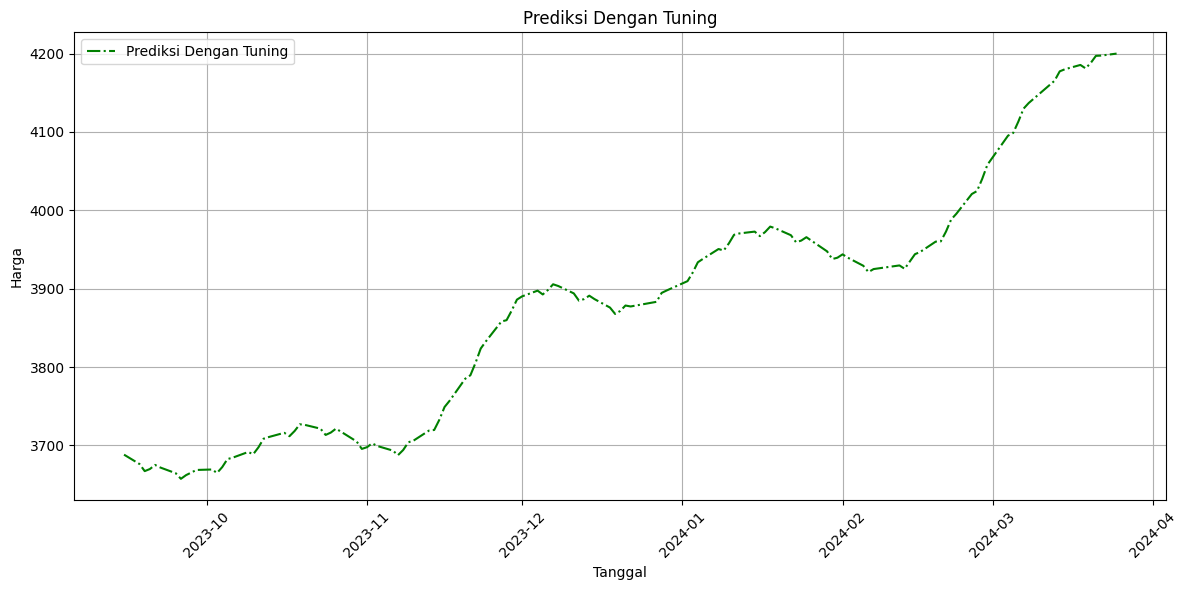

In [11]:
# Menggabungkan data uji dengan hasil prediksi tanpa dan dengan tuning
comparison = test_data.merge(
    forecast_default[['ds', 'yhat']].rename(columns={'yhat': 'Prediksi_Tanpa_Tuning'}),
    on='ds'
).merge(
    forecast_tuned[['ds', 'yhat']].rename(columns={'yhat': 'Prediksi_Dengan_Tuning'}),
    on='ds'
)

# Menampilkan tabel perbandingan
print("Tabel Perbandingan:")
print(comparison[['ds', 'y', 'Prediksi_Tanpa_Tuning', 'Prediksi_Dengan_Tuning']].head())

# Visualisasi
plt.figure(figsize=(12, 6))
# plt.plot(comparison['ds'], comparison['y'], label='Nilai Aktual', color='blue', marker='o')
# plt.plot(comparison['ds'], comparison['Prediksi_Tanpa_Tuning'], label='Prediksi Tanpa Tuning', color='orange', linestyle='--')
plt.plot(comparison['ds'], comparison['Prediksi_Dengan_Tuning'], label='Prediksi Dengan Tuning', color='green', linestyle='-.')
plt.title('Prediksi Dengan Tuning')
# plt.title('Perbandingan Prediksi Tanpa dan Dengan Tuning')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('grafik_3.png')
plt.show()

Tabel Perbandingan:
          ds     y  Prediksi_Tanpa_Tuning  Prediksi_Dengan_Tuning
0 2023-09-15  3720            3825.394559             3688.201020
1 2023-09-18  3680            3829.568218             3676.220545
2 2023-09-19  3730            3825.879759             3667.194764
3 2023-09-20  3810            3832.118492             3669.839484
4 2023-09-21  3810            3840.943925             3675.086836


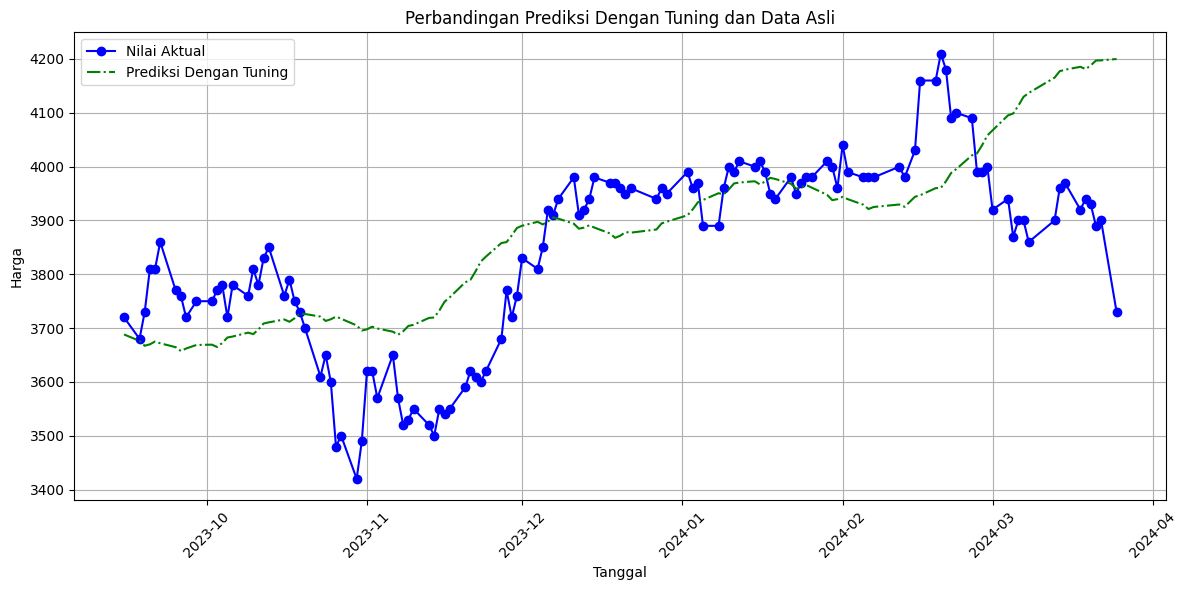

In [12]:
# Menggabungkan data uji dengan hasil prediksi tanpa dan dengan tuning
comparison = test_data.merge(
    forecast_default[['ds', 'yhat']].rename(columns={'yhat': 'Prediksi_Tanpa_Tuning'}),
    on='ds'
).merge(
    forecast_tuned[['ds', 'yhat']].rename(columns={'yhat': 'Prediksi_Dengan_Tuning'}),
    on='ds'
)

# Menampilkan tabel perbandingan
print("Tabel Perbandingan:")
print(comparison[['ds', 'y', 'Prediksi_Tanpa_Tuning', 'Prediksi_Dengan_Tuning']].head())

# Visualisasi
plt.figure(figsize=(12, 6))
plt.plot(comparison['ds'], comparison['y'], label='Nilai Aktual', color='blue', marker='o')
# plt.plot(comparison['ds'], comparison['Prediksi_Tanpa_Tuning'], label='Prediksi Tanpa Tuning', color='orange', linestyle='--')
plt.plot(comparison['ds'], comparison['Prediksi_Dengan_Tuning'], label='Prediksi Dengan Tuning', color='green', linestyle='-.')
# plt.title('Prediksi Dengan Tuning')
plt.title('Perbandingan Prediksi Dengan Tuning dan Data Asli')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('grafik_4.png')
plt.show()

In [13]:
# Menyimpan data comparison ke dalam file Excel
comparison[['ds', 'y', 'Prediksi_Tanpa_Tuning', 'Prediksi_Dengan_Tuning']].to_excel('comparison_table_2.xlsx', index=False)

print("Tabel perbandingan telah disimpan sebagai comparison_table_2.xlsx")

Tabel perbandingan telah disimpan sebagai comparison_table_2.xlsx


Tabel Perbandingan:
          ds     y  Prediksi_Tanpa_Tuning  Prediksi_Dengan_Tuning
0 2023-09-15  3720            3825.394559             3688.201020
1 2023-09-18  3680            3829.568218             3676.220545
2 2023-09-19  3730            3825.879759             3667.194764
3 2023-09-20  3810            3832.118492             3669.839484
4 2023-09-21  3810            3840.943925             3675.086836


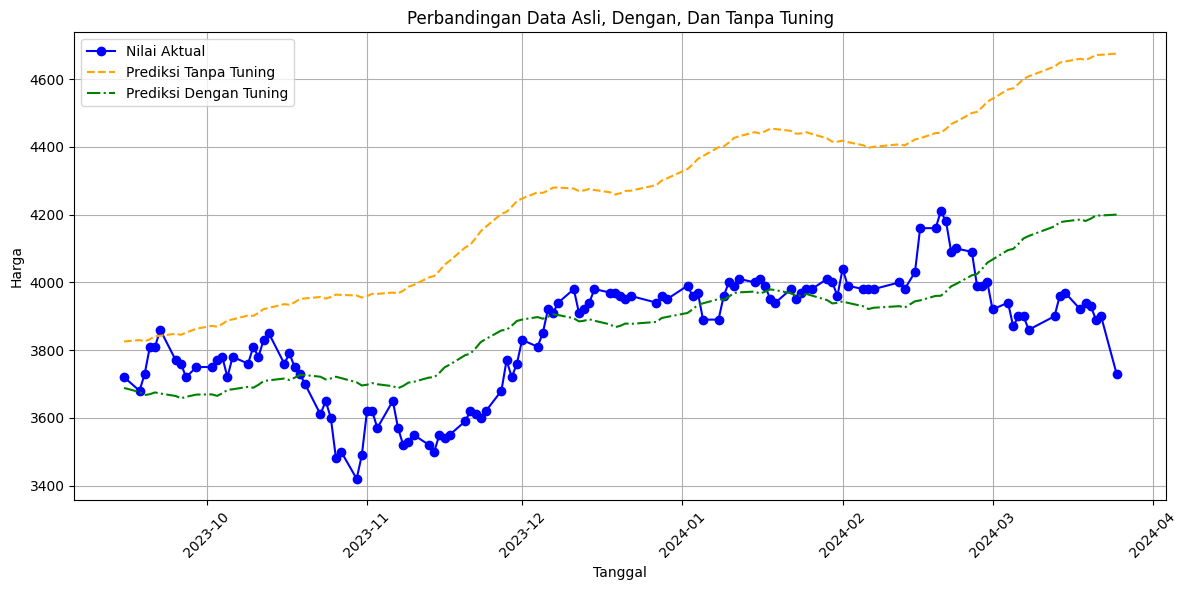

In [14]:
# Menggabungkan data uji dengan hasil prediksi tanpa dan dengan tuning
comparison = test_data.merge(
    forecast_default[['ds', 'yhat']].rename(columns={'yhat': 'Prediksi_Tanpa_Tuning'}),
    on='ds'
).merge(
    forecast_tuned[['ds', 'yhat']].rename(columns={'yhat': 'Prediksi_Dengan_Tuning'}),
    on='ds'
)

# Menampilkan tabel perbandingan
print("Tabel Perbandingan:")
print(comparison[['ds', 'y', 'Prediksi_Tanpa_Tuning', 'Prediksi_Dengan_Tuning']].head())

# Visualisasi
plt.figure(figsize=(12, 6))
plt.plot(comparison['ds'], comparison['y'], label='Nilai Aktual', color='blue', marker='o')
plt.plot(comparison['ds'], comparison['Prediksi_Tanpa_Tuning'], label='Prediksi Tanpa Tuning', color='orange', linestyle='--')
plt.plot(comparison['ds'], comparison['Prediksi_Dengan_Tuning'], label='Prediksi Dengan Tuning', color='green', linestyle='-.')
plt.title('Perbandingan Data Asli, Dengan, Dan Tanpa Tuning')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('grafik_5.png')
plt.show()


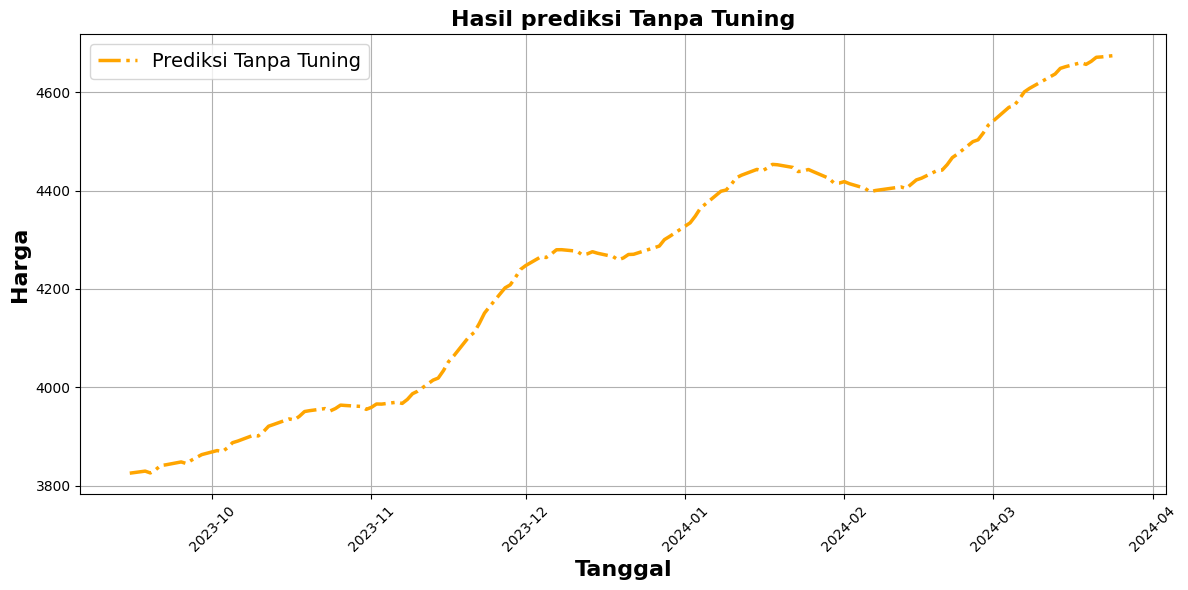

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(comparison['ds'], comparison['Prediksi_Tanpa_Tuning'], label='Prediksi Tanpa Tuning', color='orange', linestyle='-.', linewidth=2.5)
plt.title('Hasil prediksi Tanpa Tuning', fontsize=16, weight='bold')
plt.xlabel('Tanggal', fontsize=16, weight='bold')
plt.ylabel('Harga', fontsize=16, weight='bold')
plt.legend(fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('grafik_tanpa tuning.png')
plt.show()